# Анализ маркетинговой ситуации <br> для развлекательного приложения Procrastinate Pro+

## Описание проекта

**Исходная ситуация**\
Развлекательное приложения Procrastinate Pro+ несмотря на огромные вложения в рекламу, последние несколько месяцев терпит убытки.

**Задачи**:
1) Разобраться в причинах убытков.
2) Помочь компании выйти в плюс.

**Вопросы, на которые необходимо ответить**:
- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов,
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.

Имеются **данные о пользователях**, привлечённых с 01.05.2019 по 27.102019:
- лог сервера с данными о посещениях,
- выгрузка покупок за этот период,
- рекламные расходы.

## Подготовка к анализу

### Загрузка и предобработка данных

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

# отображение вывода в той же ячейке
%matplotlib inline

# глобальный вормат для десятичных дробей
pd.options.display.float_format = '{:.2f}'.format

In [2]:
# Загружаем датасеты
try:
    visits = pd.read_csv ('/datasets/visits_info_short.csv')
except:
    visits = pd.read_csv ('visits_info_short.csv')
    
try:
    orders = pd.read_csv ('/datasets/orders_info_short.csv')
except:
    orders = pd.read_csv ('orders_info_short.csv')
    
try:
    costs =  pd.read_csv ('/datasets/costs_info_short.csv') 
except:
    costs =  pd.read_csv ('costs_info_short.csv')

In [3]:
# Смотрим исходные датасеты
#display (visits.head(3))
#display (orders.head(3))
#display (costs.head(3))

In [4]:
# Функция проверки датасетов и подготовки имён столбцов
def preview(dt):
    # отображаем общую информацию
    display(dt.info())
    
    # отображаем количество строк-дубликатов
    duplicated_count = dt.duplicated().sum()
    display(f"Количество дубликатов в таблице: {duplicated_count}")
    
    # приводим имена столбцов к нижнему регистру и заменяем пробелы на '_'
    dt.columns = dt.columns.str.lower().str.replace(' ', '_')
    
    print ('')    
    return dt       

In [5]:
# Смотрим полноту и формат данных
visits = preview(visits)
orders = preview(orders)
costs = preview(costs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


None

'Количество дубликатов в таблице: 0'


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


None

'Количество дубликатов в таблице: 0'


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


None

'Количество дубликатов в таблице: 0'

Даты представлены в формате object.\
Так же целесообразно привести user_id к формату str\
**Меняем формат данных**

In [6]:
# меняем формат данных User Id в двух датасетах на str 
visits['user_id'] = visits['user_id'].astype('str')
orders['user_id'] = orders['user_id'].astype('str')

# меняем формат даn и времни 
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt'])

In [7]:
# добавляем поле "длительность сессии" - это может понадобится в дальнейшем
visits['session_duration'] = (visits['session_end'] - visits['session_start']).dt.total_seconds()

In [8]:
# проверяем после изменений форматов
display (visits.info())
display (orders.info())
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           309901 non-null  object        
 1   region            309901 non-null  object        
 2   device            309901 non-null  object        
 3   channel           309901 non-null  object        
 4   session_start     309901 non-null  datetime64[ns]
 5   session_end       309901 non-null  datetime64[ns]
 6   session_duration  309901 non-null  float64       
dtypes: datetime64[ns](2), float64(1), object(4)
memory usage: 16.6+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  object        
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 942.6+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   dt       1800 non-null   datetime64[ns]
 1   channel  1800 non-null   object        
 2   costs    1800 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 42.3+ KB


In [9]:
# проверяем неявные дубликаты в категориальных столбцах

display (visits['region'].unique())
display (visits['device'].unique())
display (visits['channel'].unique())
costs['channel'].unique()

array(['United States', 'UK', 'France', 'Germany'], dtype=object)

array(['iPhone', 'Mac', 'Android', 'PC'], dtype=object)

array(['organic', 'TipTop', 'RocketSuperAds', 'YRabbit', 'FaceBoom',
       'MediaTornado', 'AdNonSense', 'LeapBob', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit',
       'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner',
       'lambdaMediaAds'], dtype=object)

In [10]:
# Смотрим датасеты после обработки
display (visits.sample(3))
display (orders.sample(3))
costs.sample(3)

user_id         region   device  channel       session_start  \
76595   787062258087  United States   iPhone   TipTop 2019-07-15 08:46:20   
165046  615027001233  United States  Android   TipTop 2019-09-29 07:17:05   
198184  132712284041  United States      Mac  organic 2019-10-23 07:50:38   

               session_end  session_duration  
76595  2019-07-15 09:05:25           1145.00  
165046 2019-09-29 07:19:40            155.00  
198184 2019-10-23 08:15:32           1494.00

user_id            event_dt  revenue
35394  256250628623 2019-09-11 06:49:39     4.99
31607  164435357120 2019-07-24 13:33:18     4.99
28736  554491509169 2019-05-28 00:10:33     4.99

dt     channel  costs
676  2019-09-14      TipTop 472.50
553  2019-05-14      TipTop  60.00
1060 2019-10-08  AdNonSense  21.00

**Результат**:\
Пропусков в данных нет, строк-полных дубликатов нет, неявных дубликатов в категориальных столбцах нет.\
Наименования столбцов приведены к логичному виду.\
Формат дат изменён на datetime.

### Задаём функции для расчёта и анализа

Функции для вычисления значений метрик и построения графиков

#### Переменная Profiles - профили пользователей. Функция get_profiles()

In [11]:
# расширяем профиль пользователя
def get_profiles(visits, orders, costs):
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # определяем дату первого посещения
    # и месяц, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].dt.month

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # восстанавливаем формат столбца 'dt' в datetime для соответствия типам данных
    profiles['dt'] = pd.to_datetime(profiles['dt'])
    costs['dt'] = pd.to_datetime(costs['dt'])

    # считаем количество уникальных пользователей
    # с одинаковыми источниками и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # подстраховываемся - заменяем результат деления на ноль или NaN на значение 0
    ad_costs['acquisition_cost'].fillna(0, inplace=True)

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles



#### Таблица Retention Rate - коэффициенты удержания. Функция get_retention()

In [12]:
def get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # добавляем данные о визитах в профили
    result_raw = result_raw.merge(
        visits[['user_id', 'session_start']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждого визита
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу удержания
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        # не нужно суммирование, поскольку это удержание
        result = result.fillna(0)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # добавляем размеры когорт в таблицу удержания
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем retention rate
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики удержания убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time


#### CR - уровень конверсии. Функция get_conversion()

In [13]:
def get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        orders.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу конверсии
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        # считаем сумму с накоплением для каждой строки
        result = result.fillna(0).cumsum(axis = 1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # добавляем размеры когорт в таблицу конверсии
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time


#### LTV -  «пожизненная ценность» клиента. Фунуция get_ltv()

In [14]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # сохраняем в датафрейм данные пользователей и значения CAC, 
        # добавив параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

#### Фунуция filter_data() — для сглаживания данных

In [15]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

#### Фунуция plot_retention() — для построения графика Retention Rate,

In [16]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 8))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

#### Фунуция plot_conversion() — для построения графика конверсии,

In [17]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

#### Фунуция plot_ltv_roi — для визуализации LTV и ROI.

In [18]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 12))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Исследовательский анализ данных

Залачи:
- Составить профили пользователей. Определить минимальную и максимальную даты привлечения пользователей.
- Выяснить, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей.
- Узнайть, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи.
- Изучить рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей.

### Профили пользователей

In [19]:
# вызываем функцию
profiles = get_profiles(visits, orders, costs)

#добавляем признак оплаты
profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
# Создаем новый столбец с замененными значениями
profiles['payers_num'] = profiles['payer'].replace([False, True], [0, 1])

display (profiles.head ())
print ('')
print ('Количество уникальных зарегистрированных пользователей', profiles.shape)
print ('')
print ('Количество плательщиков и неплательщиков', profiles['payer'].value_counts())
print ('')

user_id            first_ts         channel   device         region  \
0  100002830880 2019-10-17 12:25:34         organic  Android  United States   
1   10000484057 2019-06-29 20:23:14  lambdaMediaAds      Mac        Germany   
2  100010021210 2019-07-19 15:29:29         LeapBob       PC             UK   
3  100018706745 2019-10-16 16:19:26          TipTop      Mac  United States   
4  100024199374 2019-08-20 15:46:46         organic  Android  United States   

          dt  month  payer  acquisition_cost  payers_num  
0 2019-10-17     10  False              0.00           0  
1 2019-06-29      6  False              0.70           0  
2 2019-07-19      7  False              0.22           0  
3 2019-10-16     10  False              3.50           0  
4 2019-08-20      8  False              0.00           0


Количество уникальных зарегистрированных пользователей (150008, 10)

Количество плательщиков и неплательщиков payer
False    141127
True       8881
Name: count, dtype: int64



Количество уникальных зарегистрированных пользователей - 150 тыс.
Из наз в дальнейнем совершили оплату сервиса 8881 человек, что почти в 16 раз меньше тех, кто оплату так и не совершил.

### Мин. и макс. даты привлечения пользователей

In [20]:
first_date = profiles['first_ts'].min()
print(f"Минимальная дата привлечения пользователей: {first_date}")
first_date = profiles['first_ts'].max()
print(f"Максимальная дата привлечения пользователей: {first_date}")

Минимальная дата привлечения пользователей: 2019-05-01 00:00:41
Максимальная дата привлечения пользователей: 2019-10-27 23:59:04


Данные охватывают пользователей, зарегистрировавшихся в период с 2019-05-01 по 2019-10-27, то есть почти за 6 месяцев.\
Это совпадает с требуемым диапазоном исследования.

### Страны как истосчник платящих пользователей

In [21]:
# Создаем сводную таблицу и добавляем рассчётные метрики
countries = profiles.pivot_table(index='region', values='payers_num', aggfunc='sum')
countries ['visitors'] = profiles.groupby('region')['user_id'].count()
countries ['payers_share'] = countries['payers_num']/ countries ['visitors']*100
countries=countries.sort_values('payers_share',ascending=False)
display(countries)


payers_num  visitors  payers_share
region                                           
United States        6902    100002          6.90
Germany               616     14981          4.11
UK                    700     17575          3.98
France                663     17450          3.80

Больше всего платящих пользователей пришли из США, как по абсолютным, так и по относительным показателям. США лидируют с заметным отрывом.\
Интересно, что группа 3-х других стран (Германия, Великобритания и Франция) равномерна, каждая из стран отстает от США в по количеству пользователей впримерно 6 раз, но по доли плательщиков разрыв значительно меньше - менее, чем в 2 раза.   

### Тип устройства пользователя в связи с фактом платежа

In [22]:
# Создаем сводную таблицу и добавляем рассчётные метрики
devices = profiles.pivot_table(index='device', values='payers_num', aggfunc='sum')
devices ['visitors'] = profiles.groupby('device')['user_id'].count()
devices ['payers_share'] = devices['payers_num']/ devices ['visitors']*100
devices=devices.sort_values('payers_share',ascending=False)
display(devices)

payers_num  visitors  payers_share
device                                     
Mac            1912     30042          6.36
iPhone         3382     54479          6.21
Android        2050     35032          5.85
PC             1537     30455          5.05

Суммарно владельцев продукции Apple среди пользователей сервиса больше, чем владельцев устройств других типов. Эта же группа наиболее часто совершает покупки на сайте.

### Каналы как истосчник платящих пользователей

In [23]:
# Создаем сводную таблицу и добавляем рассчётные метрики
channels = profiles.pivot_table(index='channel', values='payers_num', aggfunc='sum')
channels ['visitors'] = profiles.groupby('channel')['user_id'].count()
channels ['payers_share'] = channels['payers_num']/ channels ['visitors']*100
channels=channels.sort_values('visitors',ascending=False)
display(channels)

payers_num  visitors  payers_share
channel                                               
organic                   1160     56439          2.06
FaceBoom                  3557     29144         12.20
TipTop                    1878     19561          9.60
OppleCreativeMedia         233      8605          2.71
LeapBob                    262      8553          3.06
WahooNetBanner             453      8553          5.30
RocketSuperAds             352      4448          7.91
MediaTornado               156      4364          3.57
YRabbit                    165      4312          3.83
AdNonSense                 440      3880         11.34
lambdaMediaAds             225      2149         10.47

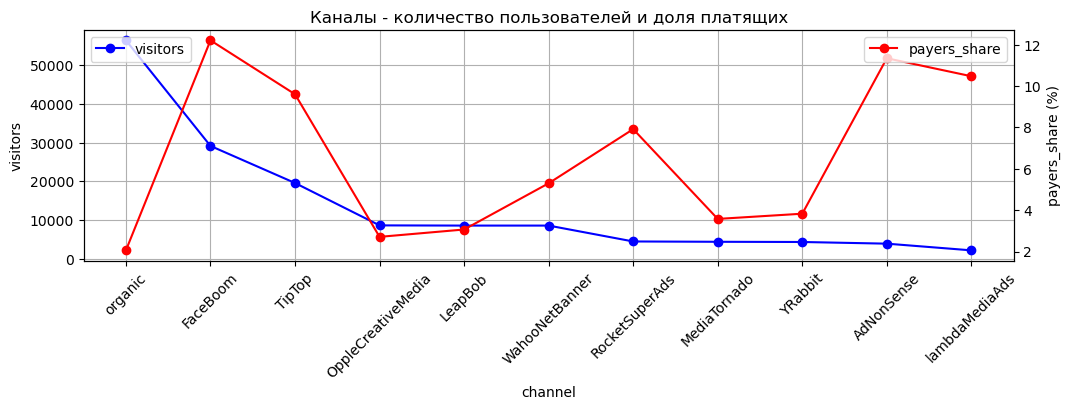

In [24]:
fig, ax1 = plt.subplots(figsize=(12, 3))

# Первая диаграмма - количество пользователей
ax1.plot(channels.index, channels['visitors'], marker='o', color='b', label='visitors')
ax1.set_xlabel('channel')
ax1.set_ylabel('visitors')
ax1.grid(True)
ax1.set_title('Каналы - количество пользователей и доля платящих')

# Поворачиваем подписи оси X на 45 градусов
ax1.set_xticks(range(len(channels.index)))
ax1.set_xticklabels(channels.index, rotation=45)

# Вторая ось Y
ax2 = ax1.twinx()

# Вторая диаграмма - доля заплативших в процентах
ax2.plot(channels.index, channels['payers_share'], marker='o', color='r', label='payers_share')
ax2.set_ylabel('payers_share (%)')
ax2.grid(False)

# Настройки легенды
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


Organic даёт наибольшее количество пользователей - в разы больше, чем другие каналы, но доля плательщиков в этом канале - наиболее низкая. На графика также можно предварительно оценить различие в качестве аудитории в зависимости от канала привлечения. На данном этапе исследования, можно сказать, что, вероятно, позиционирование сервиса в каналах FaceBoom, TipTop, AdNonSense и AdNonSense	 наиболее адекватно аудитории каналов. В каналах OppleCreativeMedia и LeapBob - наименее адекватно. Доля заплативших среди пришедших из этих каналов близка к органической.

## Маркетинг

Задачи:
- Посчитать общую сумму расходов на маркетинг.
- Выяснить, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Построить график визуализации динамики изменения расходов во времени по неделям по каждому источнику.
- Визуализировать динамику изменения расходов во времени по месяцам по каждому источнику.
- Узнать, сколько в среднем стоило привлечение одного пользователя (CFC) из каждого источника.

### Общая сумма расходов на маркетинг

In [25]:
marketing_total_sim = costs['costs'].sum()
print (marketing_total_sim)

105497.30000000002


Общая сумма, потраченная на маркетинг равна 105 497 долларов. 

### Распределение маркетинговых бюджетов по каналам привлечения

In [26]:
marketing_channels_sim = costs.pivot_table(index='channel', values='costs', aggfunc='sum').sort_values ('costs', ascending=False)
marketing_channels_sim['costs_share'] = (marketing_channels_sim['costs'] / marketing_channels_sim['costs'].sum())*100
marketing_channels_sim

costs  costs_share
channel                                 
TipTop             54751.30        51.90
FaceBoom           32445.60        30.75
WahooNetBanner      5151.00         4.88
AdNonSense          3911.25         3.71
OppleCreativeMedia  2151.25         2.04
RocketSuperAds      1833.00         1.74
LeapBob             1797.60         1.70
lambdaMediaAds      1557.60         1.48
MediaTornado         954.48         0.90
YRabbit              944.22         0.90

Лидеры по затратам TipTop и FaceBoom с большим отрывом от остальных.

### Распределение бюджетов во времени (понедельно) по каналам

In [27]:
# извлекаем номер недели
costs['week'] = costs ['dt'].dt.isocalendar().week
# группируем по неделям и каналам с помощью сводной таблицы
week_channel_costs = costs.pivot_table(index = 'channel', columns = 'week', values='costs', aggfunc='sum')
#week_channel_costs

Строим графики - бюджет по канала в динамике по неделям.


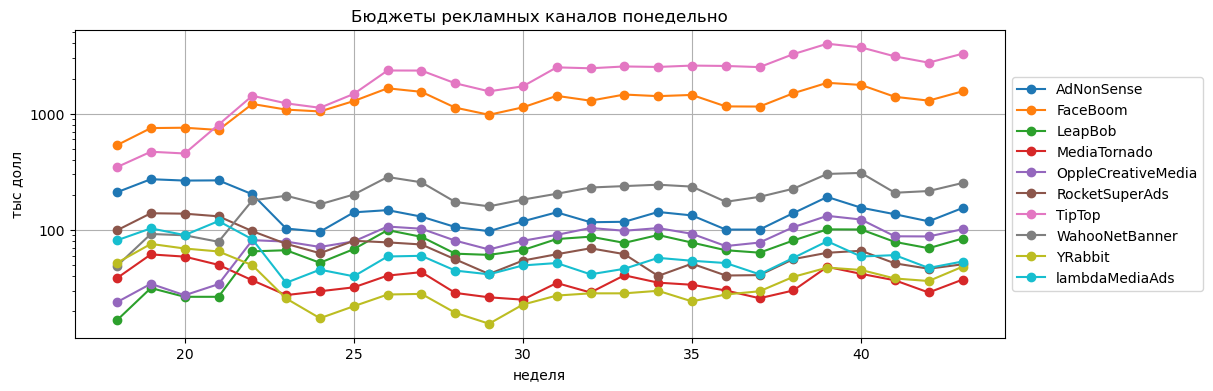

In [28]:
import matplotlib.ticker as ticker

week_channel_costs.T.plot(style='o-',grid=True, figsize=(12, 4))

plt.yscale('log')

# Настройка форматирования меток оси Y
ax = plt.gca()  # Получаем текущие оси
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())  # Используем ScalarFormatter

ax.yaxis.set_major_formatter(ticker.ScalarFormatter())  # Используем ScalarFormatter
#ax.yaxis.set_minor_formatter(ticker.ScalarFormatter())  # Применяем для минорных меток тоже

plt.title('Бюджеты рекламных каналов понедельно')
plt.xlabel('неделя')
plt.ylabel('тыс долл')

# Выносим легенду за пределы графика
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

Для оси Y применяем логарифмическую шкалу.\
Это сделано для лучшего воспариятия графиков.\
Так как разброс значений большой, в линейном режиме все графики, кроме 2-х лидеров сливаются внизу в почти сплошную массу и их динамика неразличима.

### Распределение бюджетов во времени (помесячно) по каналам

In [29]:
# извлекаем месяц из даты
costs['month'] = costs ['dt'].dt.month
# группируем по месяцам и каналам с помощью сводной таблицы
month_channel_costs = costs.pivot_table(index = 'channel', columns = 'month', values='costs', aggfunc='sum')
month_channel_costs

month                   5       6       7        8        9        10
channel                                                              
AdNonSense         1169.70  538.65  504.00   579.60   581.70   537.60
FaceBoom           3524.40 5501.10 5294.30  6274.40  6114.90  5736.50
LeapBob             140.28  314.58  313.53   369.81   343.98   315.42
MediaTornado        238.56  138.00  138.48   154.56   144.72   140.16
OppleCreativeMedia  169.75  370.00  366.50   439.25   427.75   378.00
RocketSuperAds      577.98  325.72  252.07   253.11   218.40   205.72
TipTop             2981.00 6675.60 8410.20 11202.00 13232.50 12250.00
WahooNetBanner      418.80  921.00  851.40  1040.40   977.40   942.00
YRabbit             299.70  106.20   97.38   124.74   152.79   163.41
lambdaMediaAds      458.40  199.20  219.20   220.00   247.20   213.60

Строим графики - бюджет по канала в динамике по месяцам.

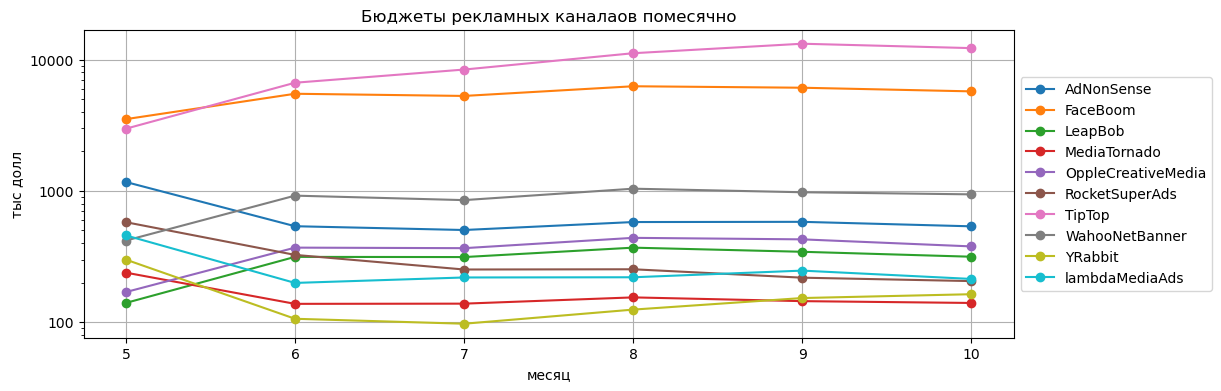

In [30]:
month_channel_costs.T.plot(style='o-',grid=True, figsize=(12, 4))

plt.yscale('log')

# Настройка форматирования меток оси Y
ax = plt.gca()  # Получаем текущие оси
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())  # Используем ScalarFormatter
#ax.yaxis.set_minor_formatter(ticker.ScalarFormatter())  # Применяем для минорных меток тоже

plt.title('Бюджеты рекламных каналаов помесячно')
plt.xlabel('месяц')
plt.ylabel('тыс долл')

# Выносим легенду за пределы графика
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

Для оси Y применяем логарифмическую шкалу. Это сделано для лучшего воспариятия графиков. Так как разброс значений большой, в линейном режиме все графики, кроме 2-х лидеров сливаются внизу в почти сплошную линию и их динамика неразличима. **Логарифмическая шкала по оси Y позволяет увидеть перераспределение в июне**.

Лидеры по бюджетам те же - TipTop и FaceBoom. Но в сравнении с понедельным графиком стали ведны некоторые нюансы - перераспределение бюджетов на июнь. У пяти каналов бюджеты снизились, а у 5 других, в том числе у лидеров - увеличились. Далее, с июля по октябрь бюджеты TipTop и YRabbit росли, хотя и разными темпами, у остальных практически не менялись.

### Сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника.

In [31]:
# Преобразование данных о времени
visits['session_start'] = pd.to_datetime(visits['session_start'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt'])

profiles = get_profiles(visits, orders, costs)

#добавляем признак оплаты
profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

profiles.head()

user_id            first_ts         channel   device         region  \
0  100002830880 2019-10-17 12:25:34         organic  Android  United States   
1   10000484057 2019-06-29 20:23:14  lambdaMediaAds      Mac        Germany   
2  100010021210 2019-07-19 15:29:29         LeapBob       PC             UK   
3  100018706745 2019-10-16 16:19:26          TipTop      Mac  United States   
4  100024199374 2019-08-20 15:46:46         organic  Android  United States   

          dt  month  payer  acquisition_cost  
0 2019-10-17     10  False              0.00  
1 2019-06-29      6  False              0.70  
2 2019-07-19      7  False              0.22  
3 2019-10-16     10  False              3.50  
4 2019-08-20      8  False              0.00

In [32]:
#Строим сводную таблицу
acquisition_cost_channel = profiles.pivot_table (index= 'channel', values= 'acquisition_cost',  aggfunc= 'mean').round(2).sort_values('acquisition_cost', ascending = False)
acquisition_cost_channel

acquisition_cost
channel                             
TipTop                          2.80
FaceBoom                        1.11
AdNonSense                      1.01
lambdaMediaAds                  0.72
WahooNetBanner                  0.60
RocketSuperAds                  0.41
OppleCreativeMedia              0.25
MediaTornado                    0.22
YRabbit                         0.22
LeapBob                         0.21
organic                         0.00

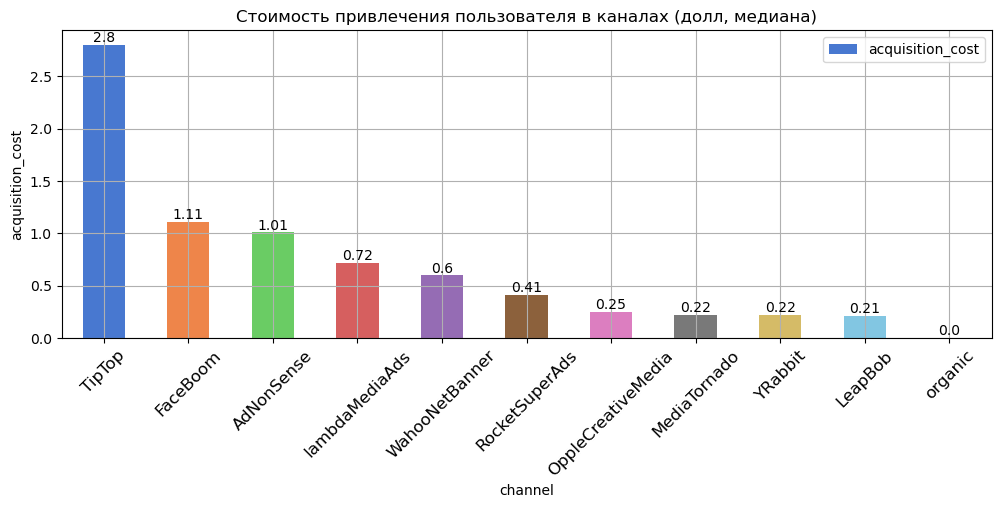

In [33]:
ax = acquisition_cost_channel.plot(kind='bar', y='acquisition_cost',
                   figsize=(12,4),
                   xlabel='channel',
                   ylabel='acquisition_cost',
                   color = sns.color_palette('muted'),
                   grid=True,
                   title='Стоимость привлечения пользователя в каналах (долл, медиана)')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=12)
plt.xticks(rotation = 45)
plt.show()

Мы видим безусловного лидера по цене привлечения - TipTop. Канал лидирует по этому показателю с отрывом почти в 2,5 раза. 

## Оценка окупаемость рекламы

**Задача**:
Используя графики LTV, ROI и CAC, проанализировать окупаемость рекламы.

Момент анализа 01.11.2019,\
горизонт анализа - 2 недели (в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения.

*Включение в анализ органических пользователей - по необходимости*.

Шаги:
- Предварительная проверка общей ситуации включая канал organic.
- Проверка конверсии пользователей и динамики её изменения. То же самое - с удержанием пользователей. Построить и изучить графики конверсии и удержания.
- Анализ общей ситуации с окупаемостью рекламы без учёта канала organic.
- Проанализировать окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализировать окупаемость рекламы с разбивкой по устройствам. Построить графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализировать окупаемость рекламы с разбивкой по странам. Построить графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализировать окупаемость рекламы с разбивкой по рекламным каналам. Построить графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

Ответить на вопросы: 
- Окупается ли реклама, направленная на привлечение пользователей в целом?
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости?

### Предварительная оценка общей ситуации
**Все платные каналы + organic, который будет удалён на следующем этапе**.

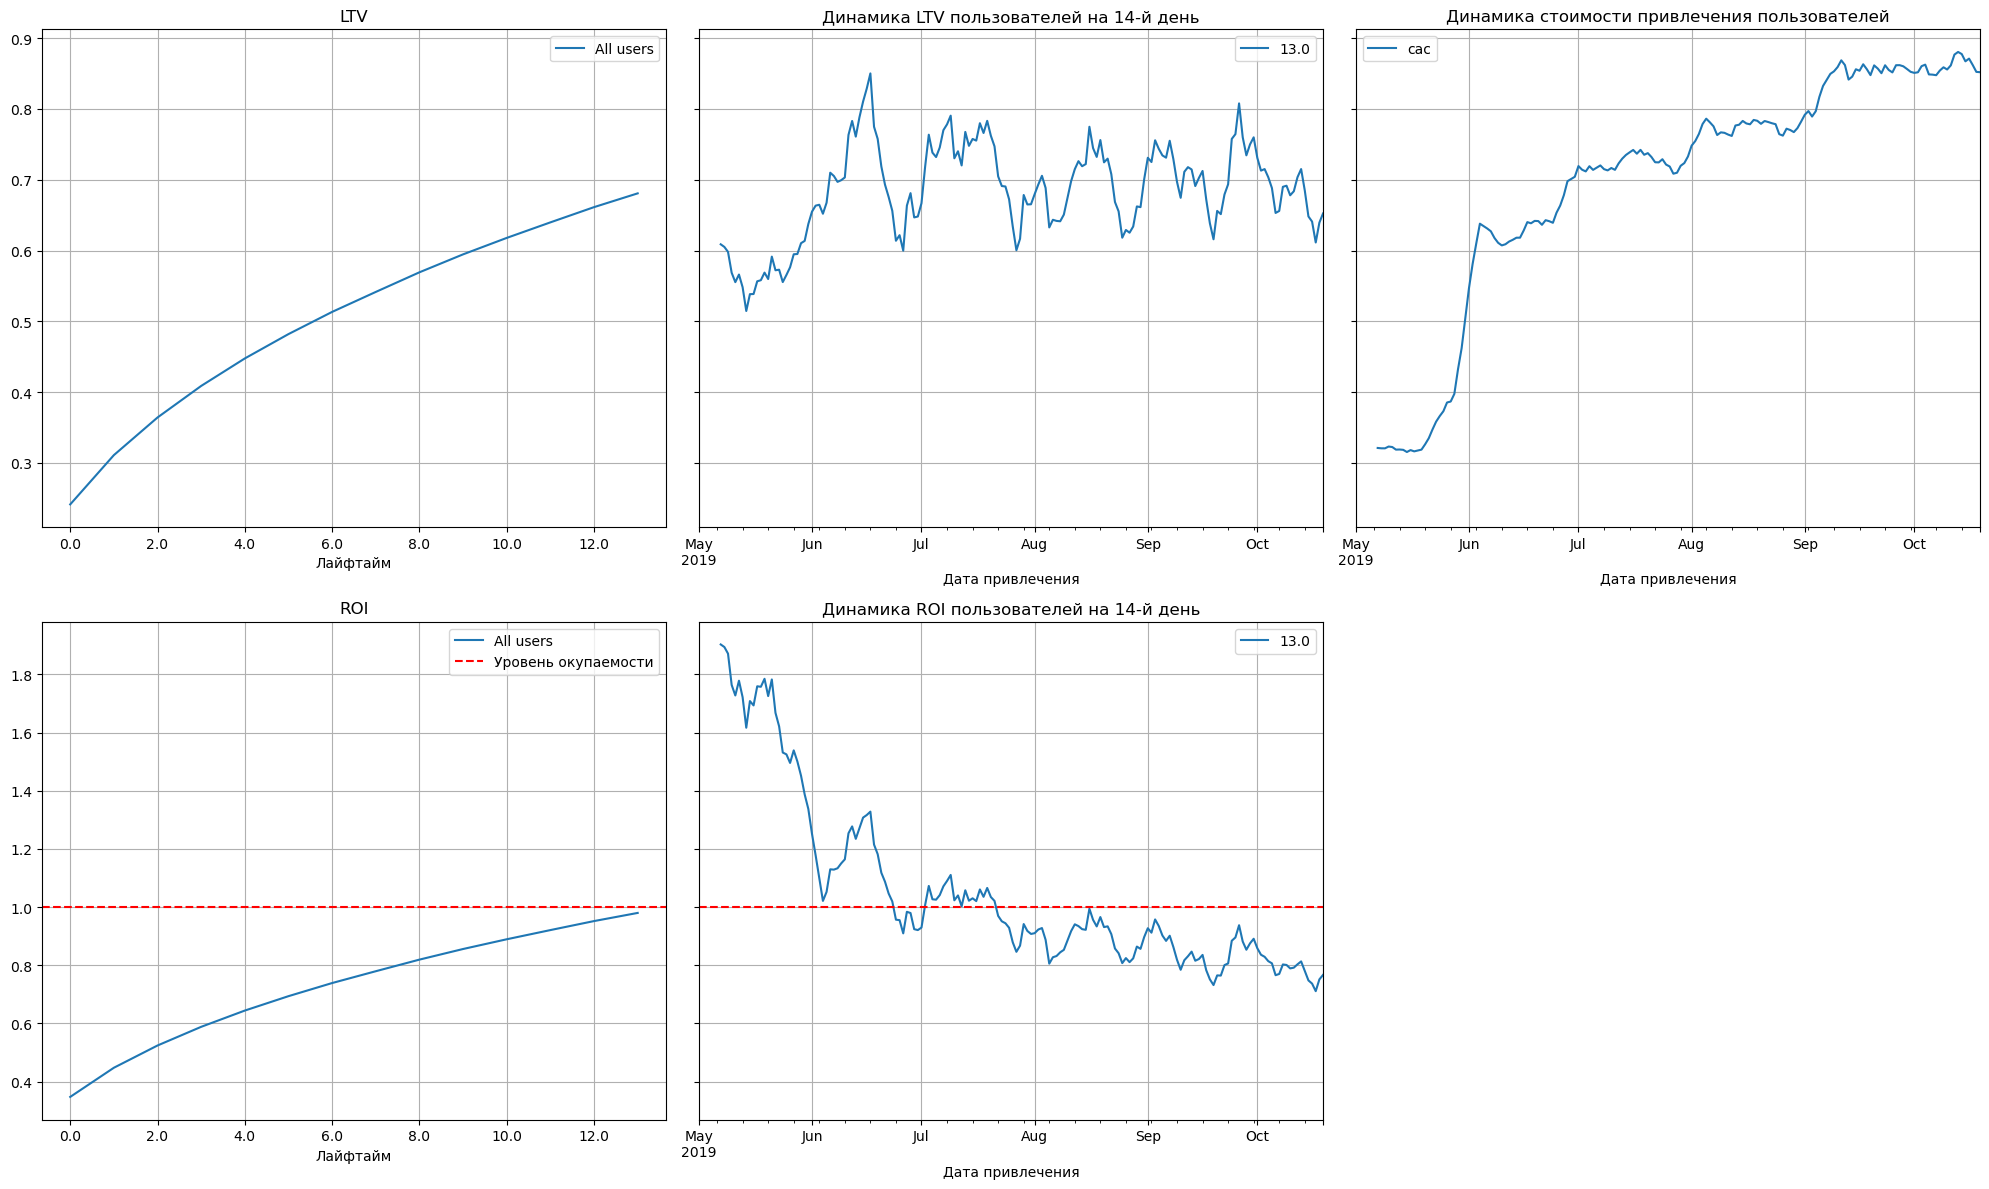

In [34]:
# рассчитываем LTV и ROI
observation_date = datetime(2019, 11, 1)  # момент анализа
analysis_horizon = 14 # горизонт анализа

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, analysis_horizon, dimensions=[])

plot_ltv_roi(ltv, ltv_history, roi, roi_history, analysis_horizon, window=7)
    
#ltv  
#roi

Так как в данном случае мы рассматриваем общую ситуацию, включая органический трафик, то ограничемся только некоторыми наблюдениями.

1. Накопленная потребительская ценность (LTV) растёт с увеличением лайфтайм. следовательно ошибок в данных нет.
2. Динамика стоимости привлечения имеет резкий рост в июне по сравнению с маем.
3. Также резко, одновременно падает показатель окупаемости.
4. При этом ценность клиента растёт.
   
Эффект можно было бы объяснить увеличением вложений в рекламу.\
**Но мы видели ранее, в разделе Маркетинг, что это не так - бюджеты были перераспределены и не имели значительного роста**.\
.

Выясним, почему при практически неизменном объеме финансирования рекламных кампаний (см. рахдел (Маркетинг), стоимость привлечения резко вырастает в июне и далее остаётся на таком же высоком уровне.
>**Гипотеза**: причина заключается в падении общего количества посетителей.\
Проверяем.

In [35]:
# группируем по месяцам и каналам с помощью сводной таблицы
month_channel_visits = profiles.pivot_table(index = 'channel', columns = 'month', values='user_id', aggfunc='count')
#month_channel_visits

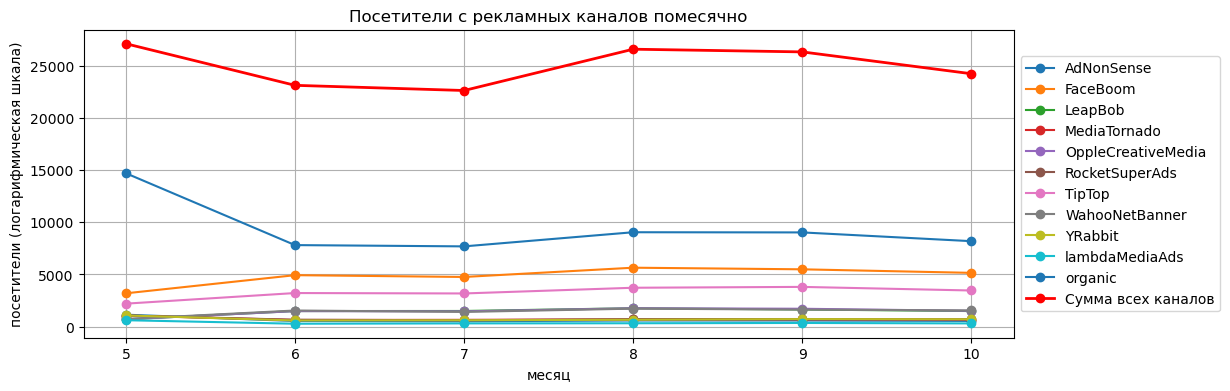

In [36]:
# рссчитываем сумму всех каналов по месяцам
month_sum = month_channel_visits.sum(axis=0)  # Суммируем значения по каналам для каждого месяца

# строим график для всех каналов
ax = month_channel_visits.T.plot(style='o-',grid=True, figsize=(12, 4))

# строим кривую для суммы всех каналов (красная)
month_sum.plot(ax=ax, style='o-', color='red', grid=True, linewidth=2, label='Сумма всех каналов')

plt.title('Посетители с рекламных каналов помесячно')
plt.xlabel('месяц')
plt.ylabel('посетители (логарифмическая шкала)')

# выносим легенду за пределы графика
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

**Гипотеза подтвердилась**.\
Рост стоимости привлечения связан с падением посещаемости сайта, которая произошла из-за почти двукратного проседания органического канала.\
**Выводы**:
1. Маркетологи компании сосредоточили внимание на развитии платных каналов, забыв про органику. Мы уже видели (см. раздел Маркетинг), что в мае произошли изменения, как минимум были перераспрелделены бюджеты. По всей видимости, изменения были и в других направлениях.
В этот же период проседает органика. Понять маркетологов можно - конверсия в органике обычно не высока. Но обрушить этот канал в два раза - вряд ли это было в планах. Очевидно, речь может идти об ощибке в работе с каналом.
2. Компенсировались ли потери ростом в других каналах? Мы видим, что только к августу общая посещаемость вернулась на прежний уровень. **Красная линия на графике** иллюстрирует это. Не надо забывать, что этот возврат стоил денег.
3. Мы уже видели, что платные каналы имеют большую, чем органика долю платящих посльзоватедей. Но фак в том, что вложения на их привлечение не достигают точки окупаемости.

>**Рекомендация маркетологам** - обратить внимание и выявить причины падения органического канала и причины его низкой конверции.

### Окупаемость рекламы (**только платные каналы**), LTV и ROI. Графики динамики LTV, CAC и ROI

**Убираем канал organic из расчётов**

In [37]:
# Убираем канал organic из расчётов
profiles = profiles[profiles['channel'] != 'organic']
visits = visits[visits['channel'] != 'organic']

# проверяем
display (visits['channel'].unique())
profiles['channel'].unique()

array(['TipTop', 'RocketSuperAds', 'YRabbit', 'FaceBoom', 'MediaTornado',
       'AdNonSense', 'LeapBob', 'WahooNetBanner', 'OppleCreativeMedia',
       'lambdaMediaAds'], dtype=object)

array(['lambdaMediaAds', 'LeapBob', 'TipTop', 'FaceBoom', 'YRabbit',
       'WahooNetBanner', 'OppleCreativeMedia', 'AdNonSense',
       'RocketSuperAds', 'MediaTornado'], dtype=object)

Расчитываем LTV и ROI

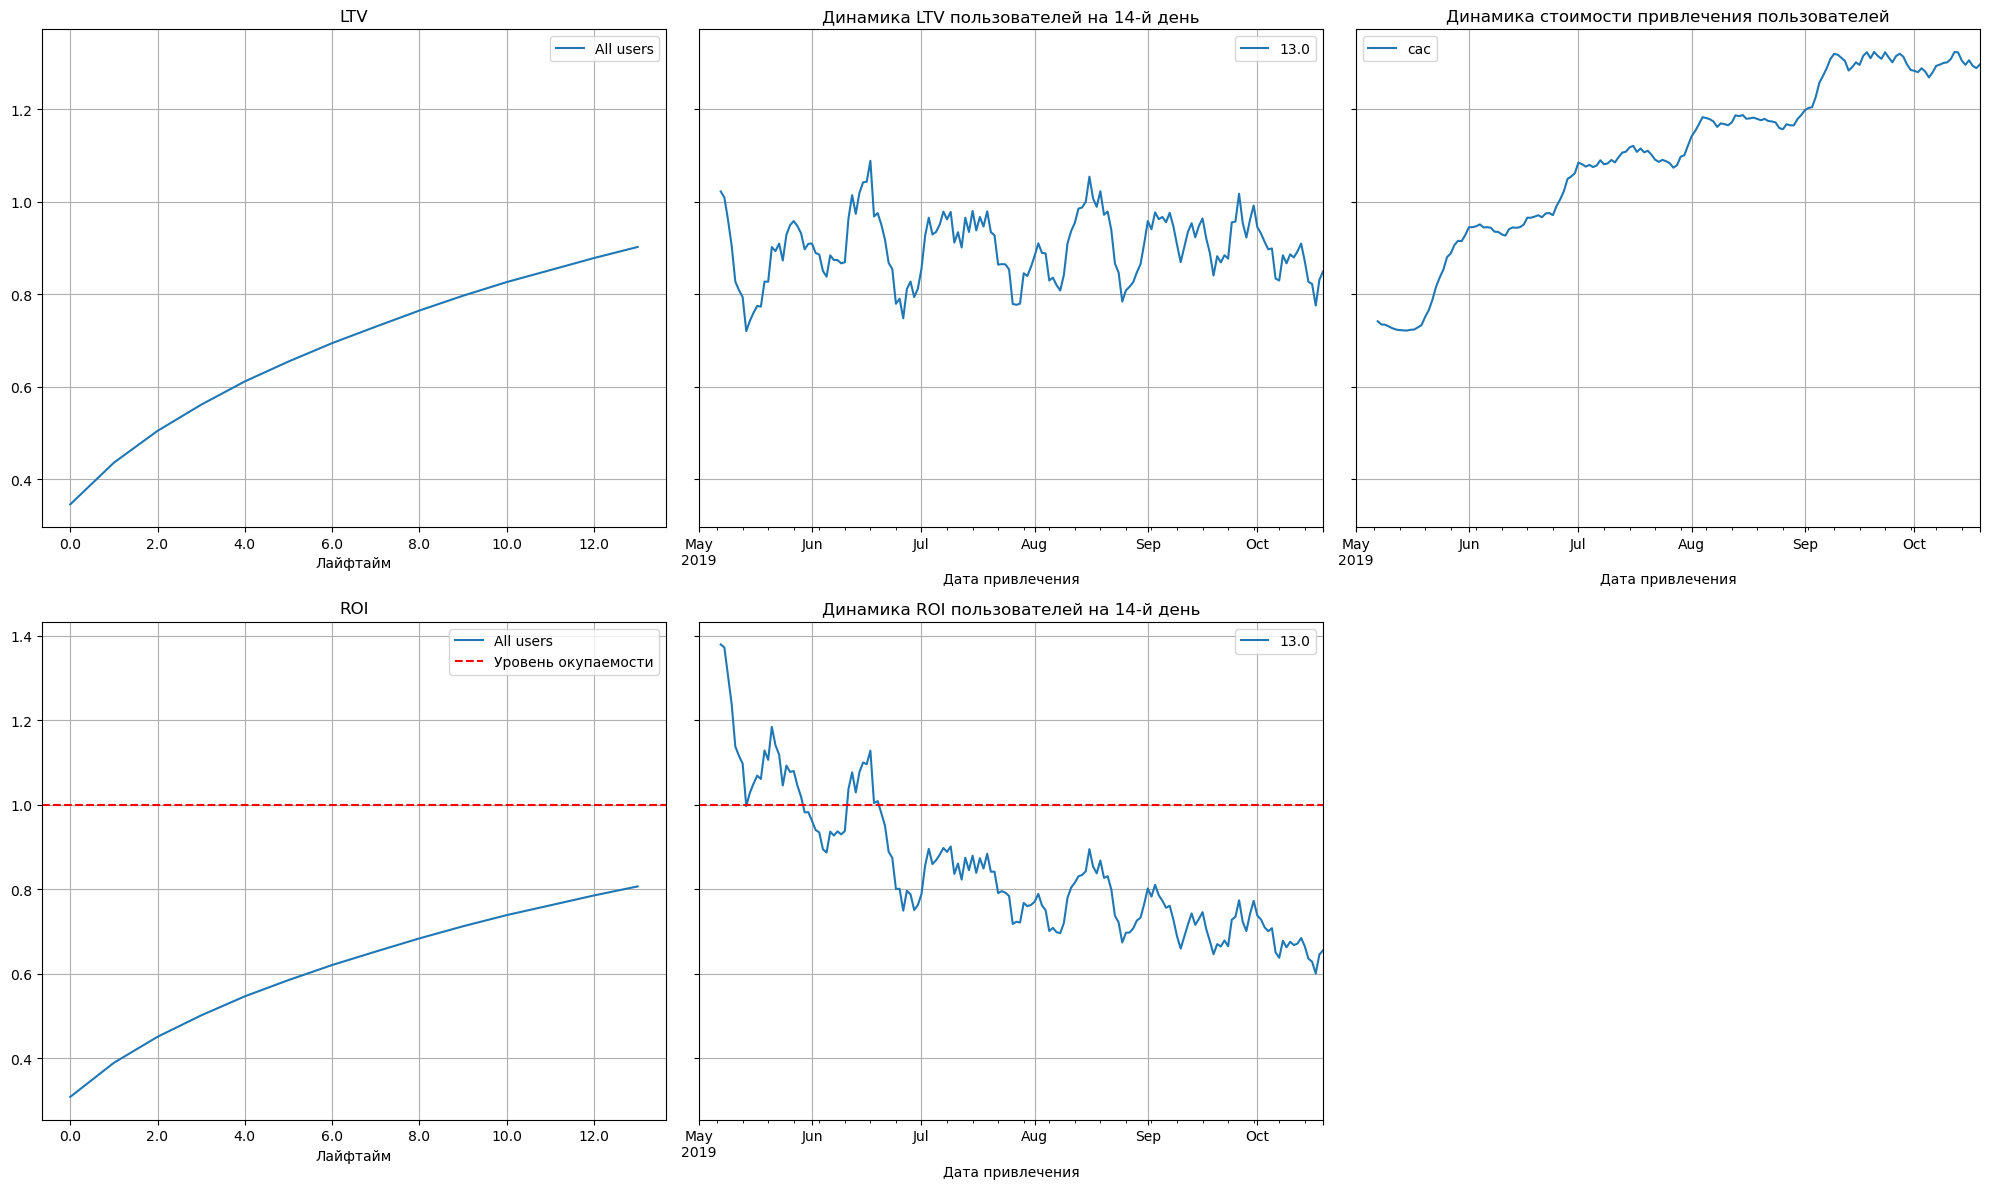

In [38]:
# расчитываем LTV и ROI
observation_date = datetime(2019, 11, 1)  # момент анализа
analysis_horizon = 14 # горизонт анализа

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, analysis_horizon, dimensions=[])

plot_ltv_roi(ltv, ltv_history, roi, roi_history, analysis_horizon, window=7)
    
#ltv  
#roi

- Накопленная потребительская ценность (LTV) растёт с увеличением лайфтайм. следовательно ошибок в данных нет.
- В динамике LTV стабильна - значения располагаются на уровне 0.9 с регулярными пиками и провалами, что связано с проведением рекламных кампаний.
- Стоимость привлечения растёт из месяца в месяц.
- Динамика окупаемости:\
  явно виден понижающий тренд, как следствие роста затрат на привлечение при относительно постоянном LTV.\
   с лругой стороны, ROI по форме следует за динамикой LTV - видна та же связь с рекламными активностями (во начале рекламных кампаний окупаемость растёт с одновременным ростом объёма платежей клиентов).
- График ROI показывает нам, что данный показатель (за весь рассматриваемый период по всём типам клиентов суммарно) на 14-ый день жизни клиента (а это целевой показатель) не достигает уровня окупаемости.

Предварительные выводы. С каждым месяцем:

- Сумма, на которую клиенты делают покупки в системе, существенно не меняется,
- Себестоимость привлечения растёт,
- Окупаемость рекламы падает.


**Целевой показатель - полная окупаемость привлечения на 14 "день жизни" клиента - не достигается**.

### Удержание по странам

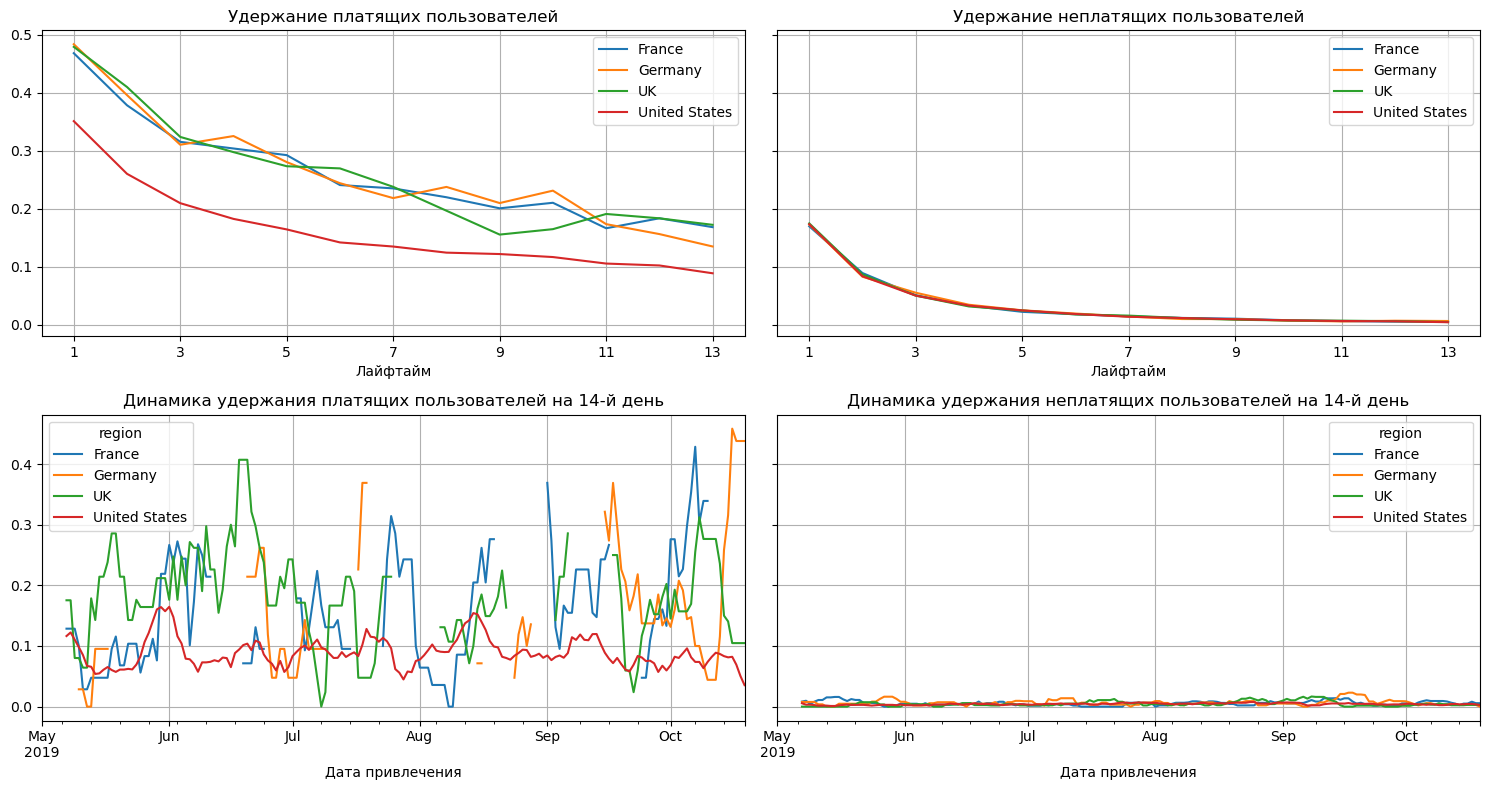

In [39]:
# вызываем функции
# задаём момент анализа и горизонт 
observation_date = datetime(2019, 11, 1)  # момент анализа
analysis_horizon = 14 # горизонт анализа

retention_raw, retention, retention_history = get_retention(
    profiles, visits, observation_date, analysis_horizon, dimensions=['region', 'payer'])

plot_retention(retention, retention_history, analysis_horizon, 7) 
#display (retention_raw)
#display(retention)
#retention_history

**Выводы**\
Удержание платящих посетителей из США на 14-ый день, ниже, чем у остальных.\
Удержание неплатящих посетителей по всем странам одинаковое.
> Я бы объяснил более низкий уровень удержания (при высокой конверсии, что мы увидим дальше) ментальными особенностями. Американцы быстрее принимают решение о получении максимольного сервиса, но и отказываются от неинтересного им быстрее. То есть, это более динамичная модель поведения, чем у европейцев.

### Удержание по устройствам

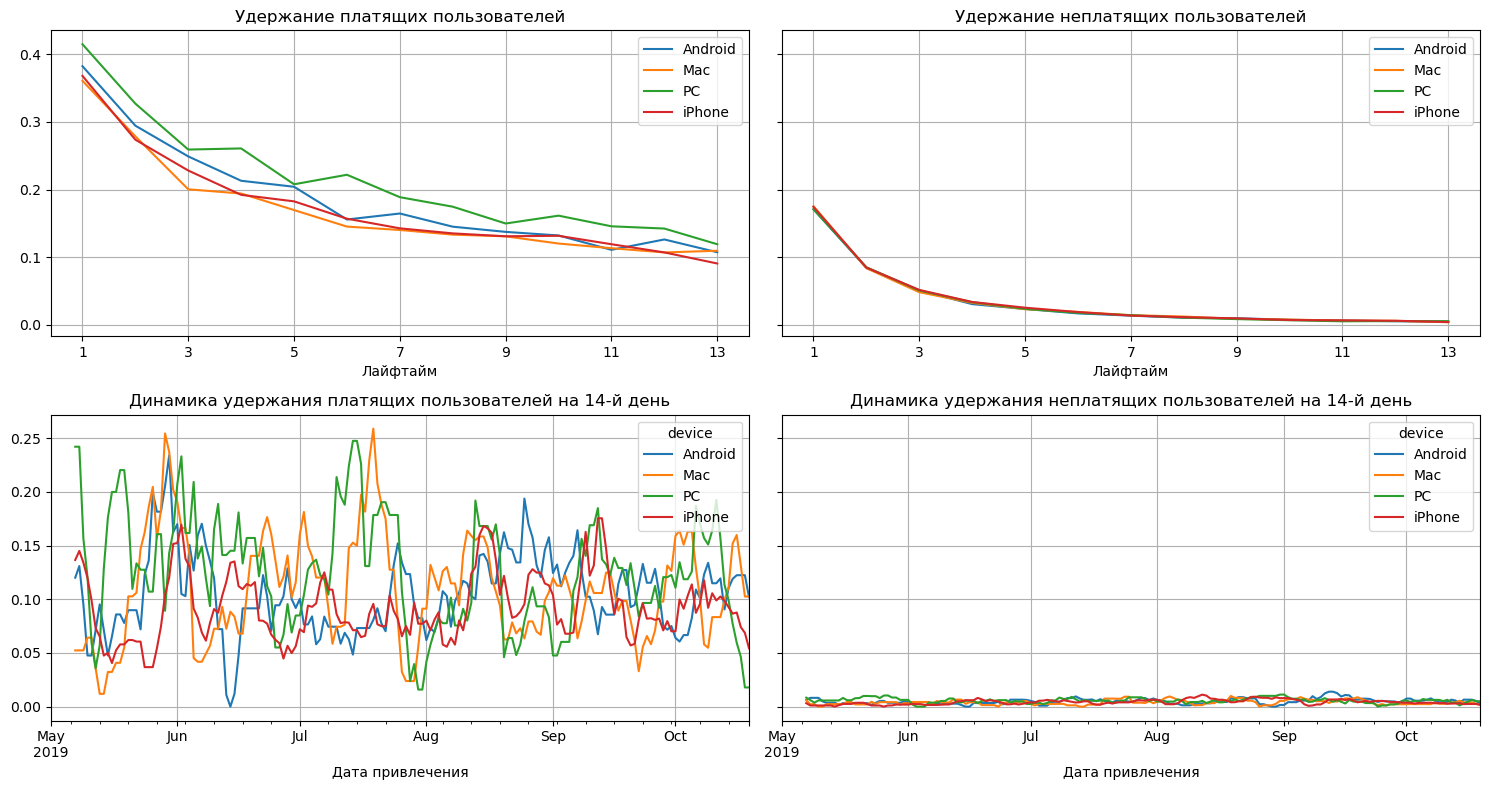

In [40]:
# вызываем функции
# задаём момент анализа и горизонт 
observation_date = datetime(2019, 11, 1)  # момент анализа
analysis_horizon = 14 # горизонт анализа

retention_raw, retention, retention_history = get_retention(
    profiles, visits, observation_date, analysis_horizon, dimensions=['device', 'payer'])

plot_retention(retention, retention_history, analysis_horizon, 7) 
#display (retention_raw)
#display(retention)
#retention_history

**Наблюдения**\
Поведение пользователей различных устройств практически совпадает.\
Есть колебания удержания на 14-ый "дней жизни" по месяцам, но их анализ целесообразен при сравнении собственно самих рекламных кампаний между собой, что не является темой данного исследованиия.

### Удержание по каналам

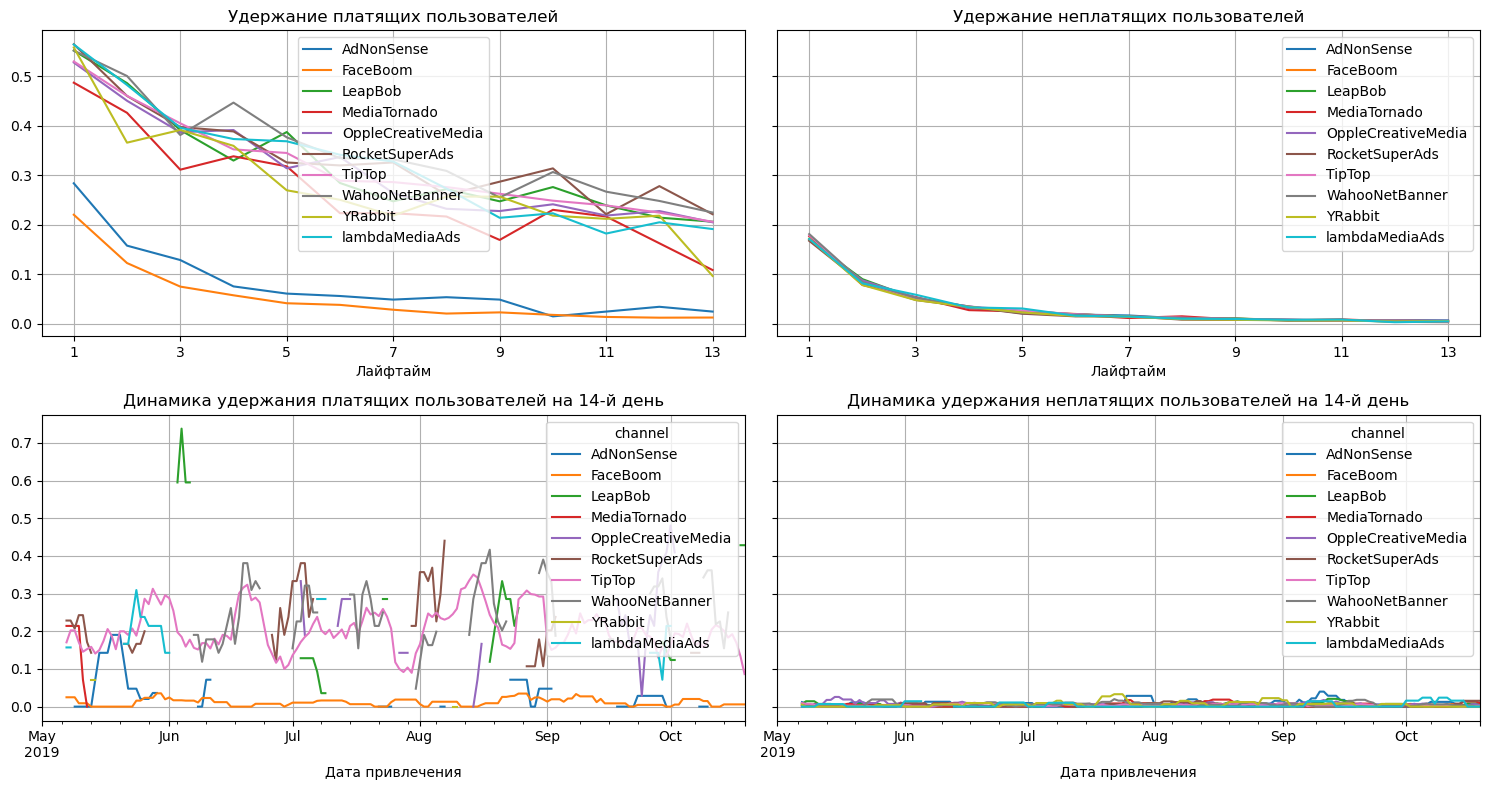

In [41]:
# вызываем функции
# задаём момент анализа и горизонт 
observation_date = datetime(2019, 11, 1)  # момент анализа
analysis_horizon = 14 # горизонт анализа

retention_raw, retention, retention_history = get_retention(
    profiles, visits, observation_date, analysis_horizon, dimensions=['channel', 'payer'])

plot_retention(retention, retention_history, analysis_horizon, 7) 
#display (retention_raw)
#display(retention)
#retention_history

**Наблюдения**\
Два канала имеют более низкое значение удержания на 14 день, чем остальные. И это платные каналы - AdNonSense и FaceBoom.

### Конверсия по странам

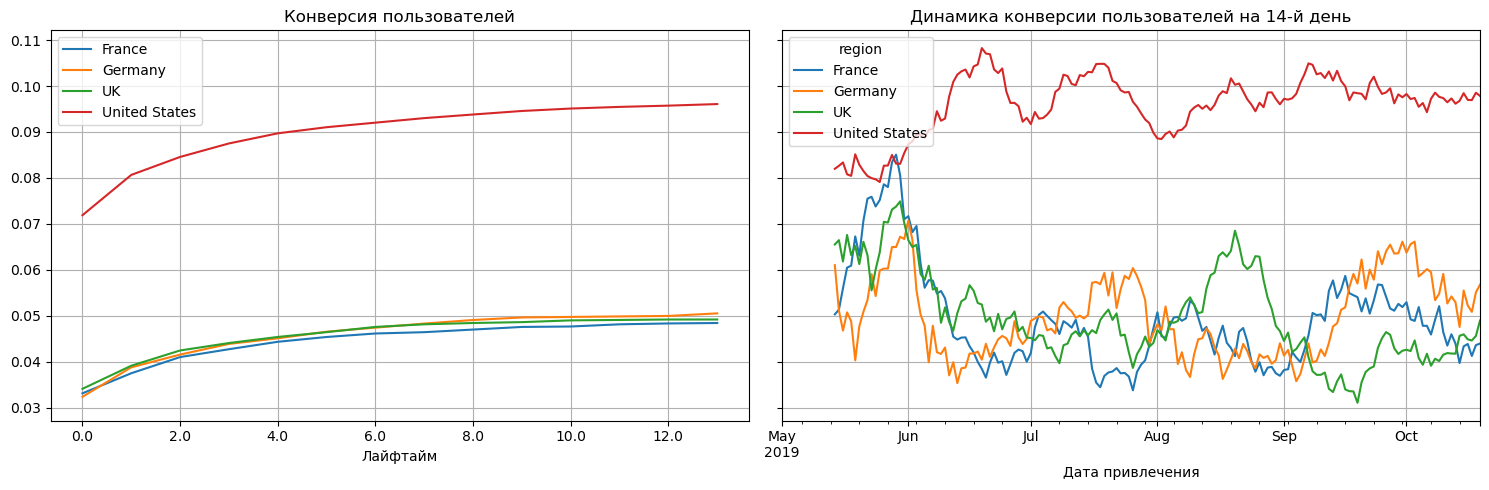

cohort_size  0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0  \
region                                                                         
France               10516 0.03 0.04 0.04 0.04 0.04 0.05 0.05 0.05 0.05 0.05   
Germany               9030 0.03 0.04 0.04 0.04 0.05 0.05 0.05 0.05 0.05 0.05   
UK                   10536 0.03 0.04 0.04 0.04 0.05 0.05 0.05 0.05 0.05 0.05   
United States        58562 0.07 0.08 0.08 0.09 0.09 0.09 0.09 0.09 0.09 0.09   

               10.0  11.0  12.0  13.0  
region                                 
France         0.05  0.05  0.05  0.05  
Germany        0.05  0.05  0.05  0.05  
UK             0.05  0.05  0.05  0.05  
United States  0.10  0.10  0.10  0.10

In [42]:
# задаём момент анализа и горизонт 
observation_date = datetime(2019, 11, 1)  # момент анализа
analysis_horizon = 14 # горизонт анализа

# получаем сырые данные, таблицу конверсии и таблицу динамики конверсии
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date, analysis_horizon, dimensions=['region'])

plot_conversion(conversion, conversion_history, analysis_horizon, window=14) 
#display (conversion_raw)
display (conversion)
#conversion_history

- Лидер по показателю конверсии - США.
- **Обратим внимание, что рост конверсии посетителей из СЩА в июне, совподает с падением конверсии других стран**.

### Конверсия по устройствам

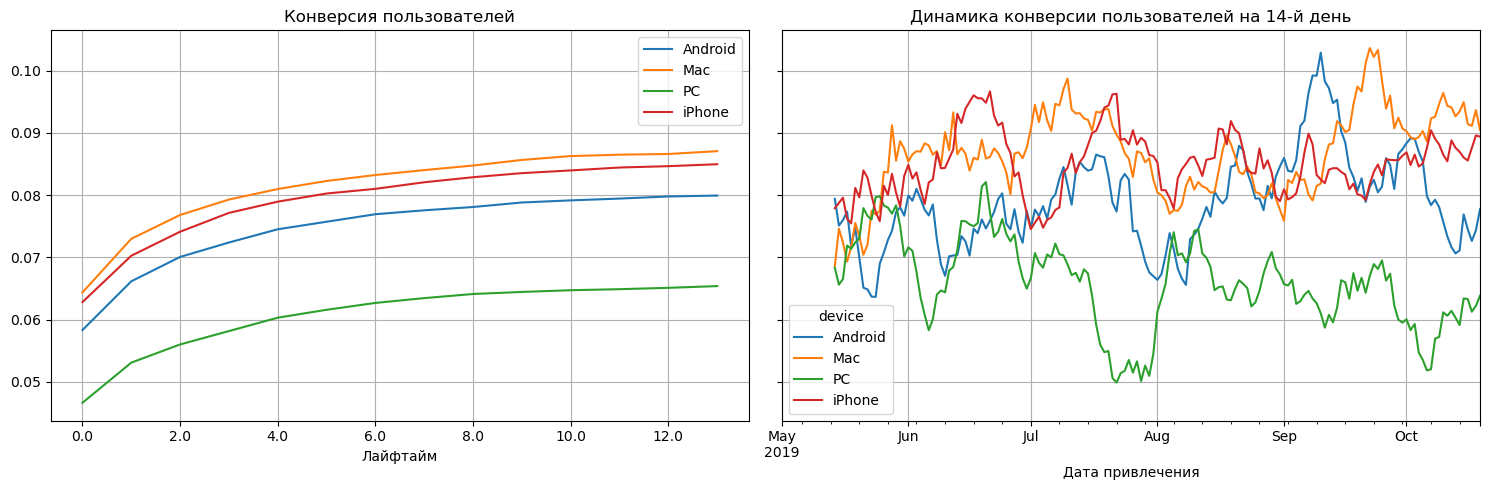

cohort_size  0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0  10.0  \
device                                                                         
Android        20683 0.06 0.07 0.07 0.07 0.07 0.08 0.08 0.08 0.08 0.08  0.08   
Mac            17747 0.06 0.07 0.08 0.08 0.08 0.08 0.08 0.08 0.08 0.09  0.09   
PC             18128 0.05 0.05 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06  0.06   
iPhone         32086 0.06 0.07 0.07 0.08 0.08 0.08 0.08 0.08 0.08 0.08  0.08   

         11.0  12.0  13.0  
device                     
Android  0.08  0.08  0.08  
Mac      0.09  0.09  0.09  
PC       0.06  0.07  0.07  
iPhone   0.08  0.08  0.08

In [43]:
# задаём момент анализа и горизонт 
observation_date = datetime(2019, 11, 1)  # момент анализа
analysis_horizon = 14 # горизонт анализа

# получаем сырые данные, таблицу конверсии и таблицу динамики конверсии
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date, analysis_horizon, dimensions=['device'])

plot_conversion(conversion, conversion_history, analysis_horizon, window=14) 
#display (conversion_raw)
display (conversion)
#conversion_history

- Уровень конверсии пользователей PC ниже остальных. Он был ниже других в начале исследуемого периода и продалал снижаться, хотя и не равномерно.
 > Явно сказываются особенности сервиса - он более удобен для мобильных девайсов, чем для PС.  
- У пользователей Android конверсия очень нестабильна.
- Конверсия пользователей Apple наиболее высокая. В динамике выден рост в июне и достаточно устойчивое лидерство в последующие месяцы. 

### Конверсия по каналам

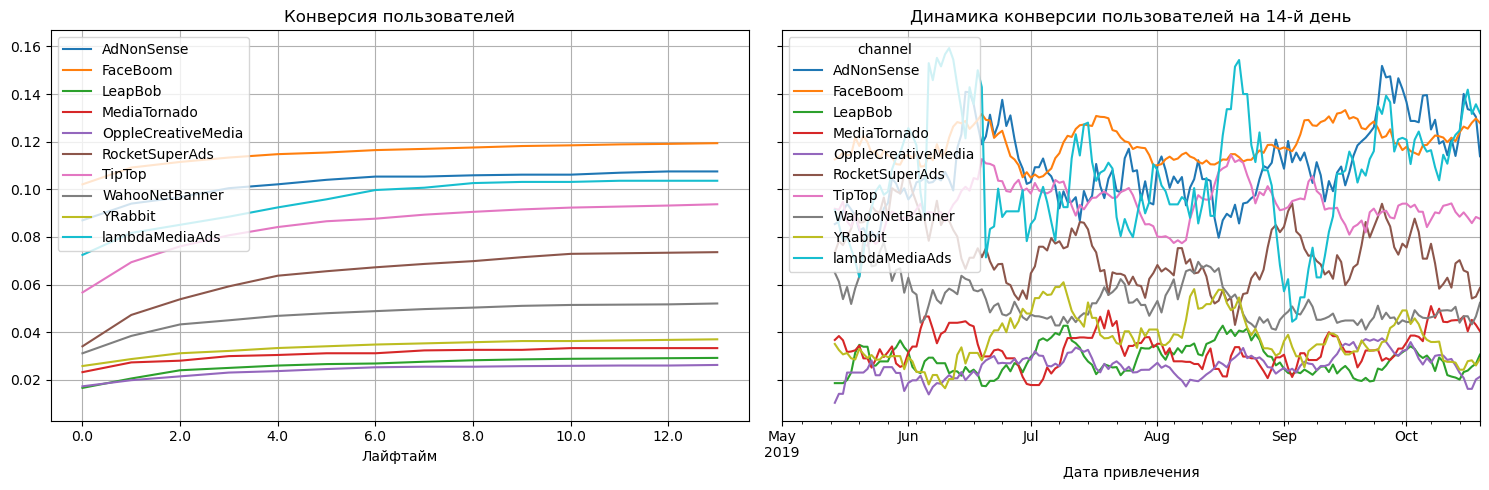

cohort_size  0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  \
channel                                                                        
AdNonSense                 3702 0.09 0.09 0.10 0.10 0.10 0.10 0.11 0.11 0.11   
FaceBoom                  27544 0.10 0.11 0.11 0.11 0.11 0.12 0.12 0.12 0.12   
LeapBob                    8103 0.02 0.02 0.02 0.03 0.03 0.03 0.03 0.03 0.03   
MediaTornado               4167 0.02 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03   
OppleCreativeMedia         8139 0.02 0.02 0.02 0.02 0.02 0.02 0.03 0.03 0.03   
RocketSuperAds             4251 0.03 0.05 0.05 0.06 0.06 0.07 0.07 0.07 0.07   
TipTop                    18498 0.06 0.07 0.08 0.08 0.08 0.09 0.09 0.09 0.09   
WahooNetBanner             8082 0.03 0.04 0.04 0.05 0.05 0.05 0.05 0.05 0.05   
YRabbit                    4102 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.04 0.04   
lambdaMediaAds             2056 0.07 0.08 0.09 0.09 0.09 0.10 0.10 0.10 0.10   

                    9.0  10.0  11.0  12.0  13.0  
channel                                          
AdNonSense         0.11  0.11  0.11  0.11  0.11  
FaceBoom           0.12  0.12  0.12  0.12  0.12  
LeapBob            0.03  0.03  0.03  0.03  0.03  
MediaTornado       0.03  0.03  0.03  0.03  0.03  
OppleCreativeMedia 0.03  0.03  0.03  0.03  0.03  
RocketSuperAds     0.07  0.07  0.07  0.07  0.07  
TipTop             0.09  0.09  0.09  0.09  0.09  
WahooNetBanner     0.05  0.05  0.05  0.05  0.05  
YRabbit            0.04  0.04  0.04  0.04  0.04  
lambdaMediaAds     0.10  0.10  0.10  0.10  0.10

In [44]:
# задаём момент анализа и горизонт 
observation_date = datetime(2019, 11, 1)  # момент анализа
analysis_horizon = 14 # горизонт анализа

# получаем сырые данные, таблицу конверсии и таблицу динамики конверсии
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date, analysis_horizon, dimensions=['channel'])

plot_conversion(conversion, conversion_history, analysis_horizon, window=14) 
#display (conversion_raw)
display (conversion)
#conversion_history

- **Лидеры по показателю конверсии (в порядке убывания - это нам пригодится) FaceBoom, AdNonSense, lambdaMediaAds, TipTop**.
- Среднее положение у RocketSuperAds
- Выражена группа аутсайлеров LeapBob, MediaTornado, OppleCreativeMedia, YRabbit. 

### LTV и ROI. Графики динамики LTV, CAC и ROI по странам

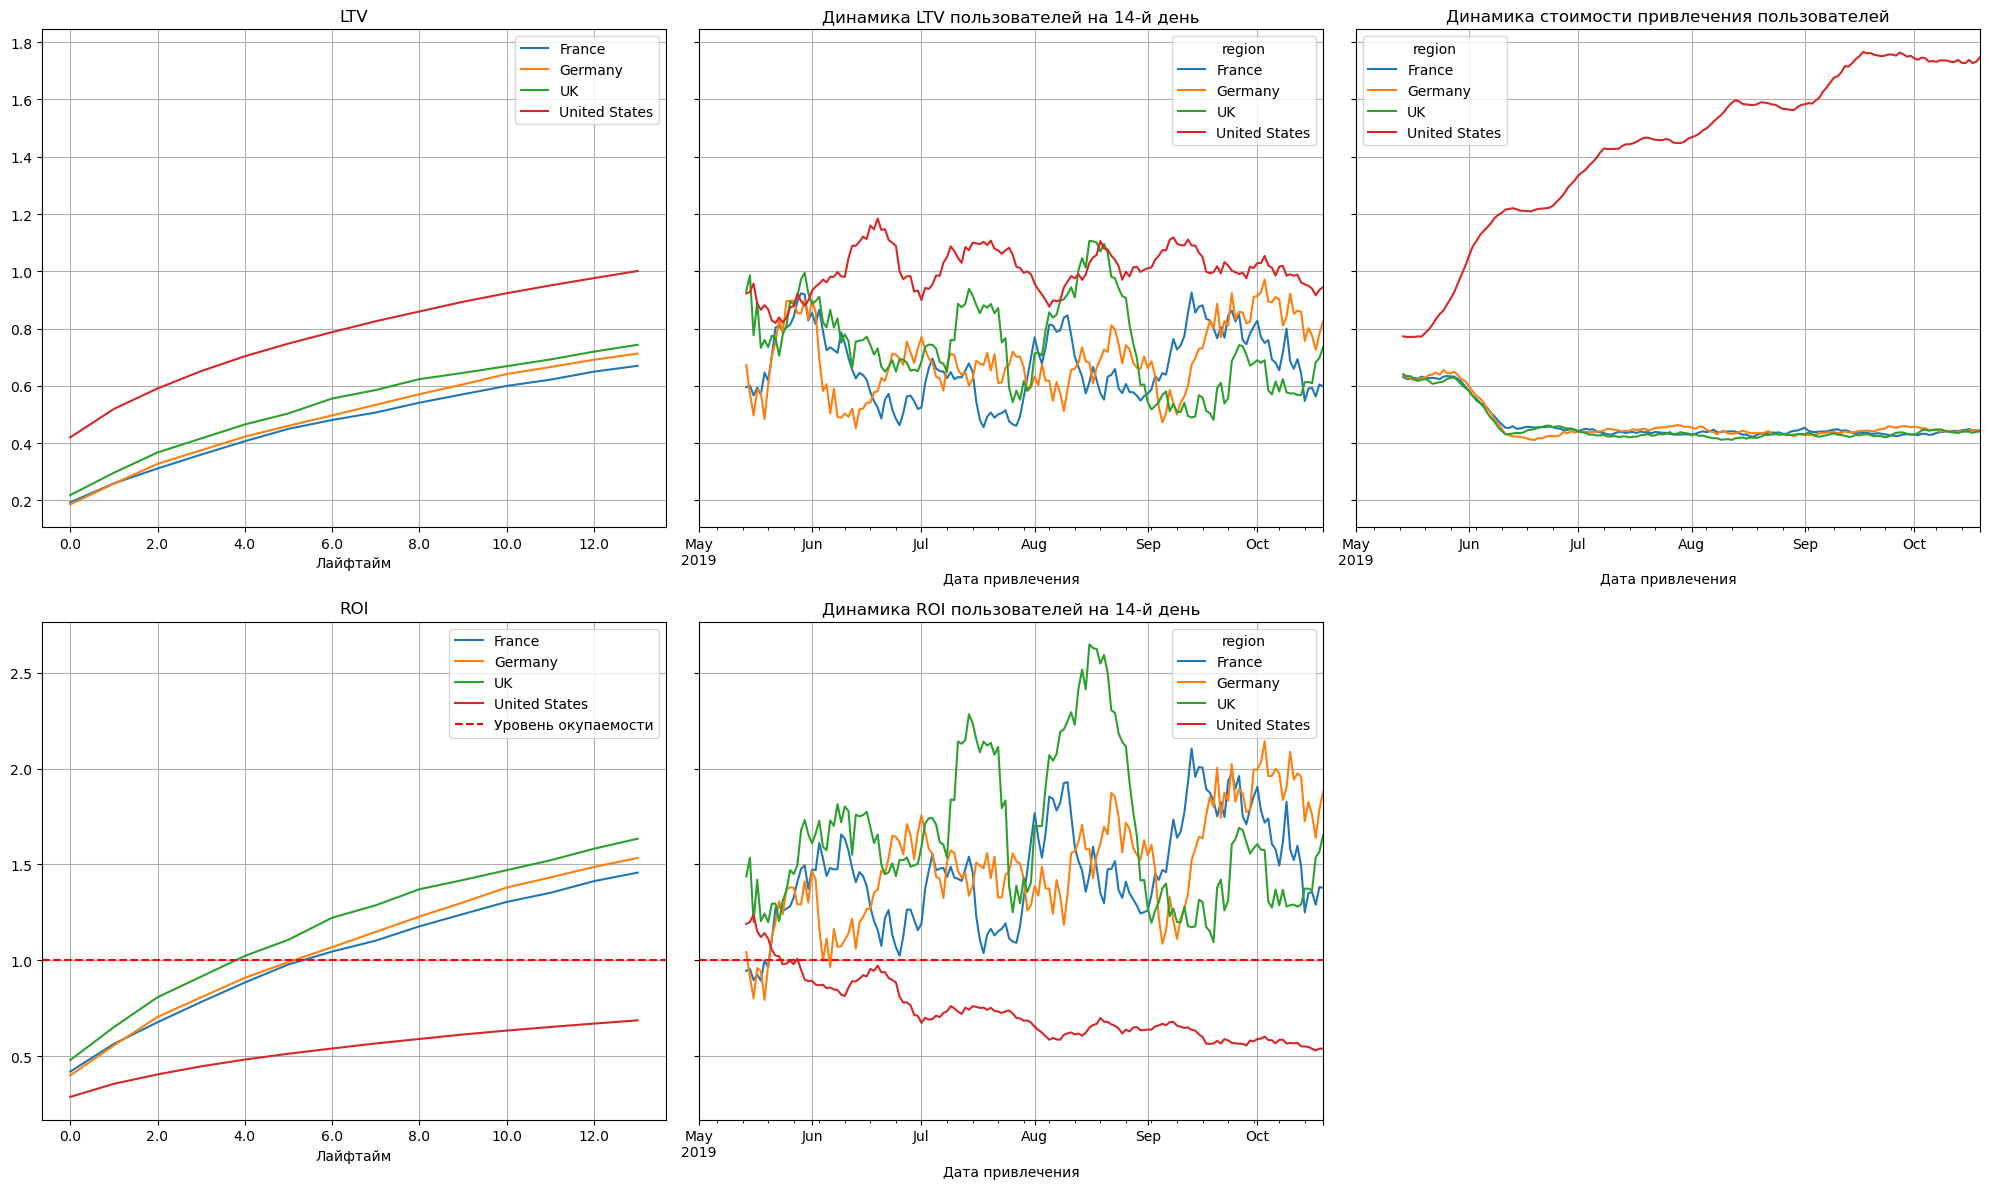

In [45]:
# рассчитываем LTV и ROI
observation_date = datetime(2019, 11, 1)  # момент анализа
analysis_horizon = 14 # горизонт анализа

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, analysis_horizon, dimensions=['region'])

plot_ltv_roi(ltv, ltv_history, roi, roi_history, analysis_horizon, window=14)
    
#ltv
#roi

- **Группа пользователей из США не окупает затраты на привлечение**.
- При том, что LTV у них вышее, чем и у других, окупаемлсть рекламы для СЩА постоянно падает.
- Стоимость их привдлечени посетителя из США резко выросла в июне на фоне снижения показателя других стран, и растёт весь наблюдаемый период.
- Окупаемость рекламы у европейских стран выше единицы - реклама окупается уже на 6-й лайфтайм.
- Реклама в США не достигает точки окупаемости.

### LTV и ROI. Графики динамики LTV, CAC и ROI по устройствам

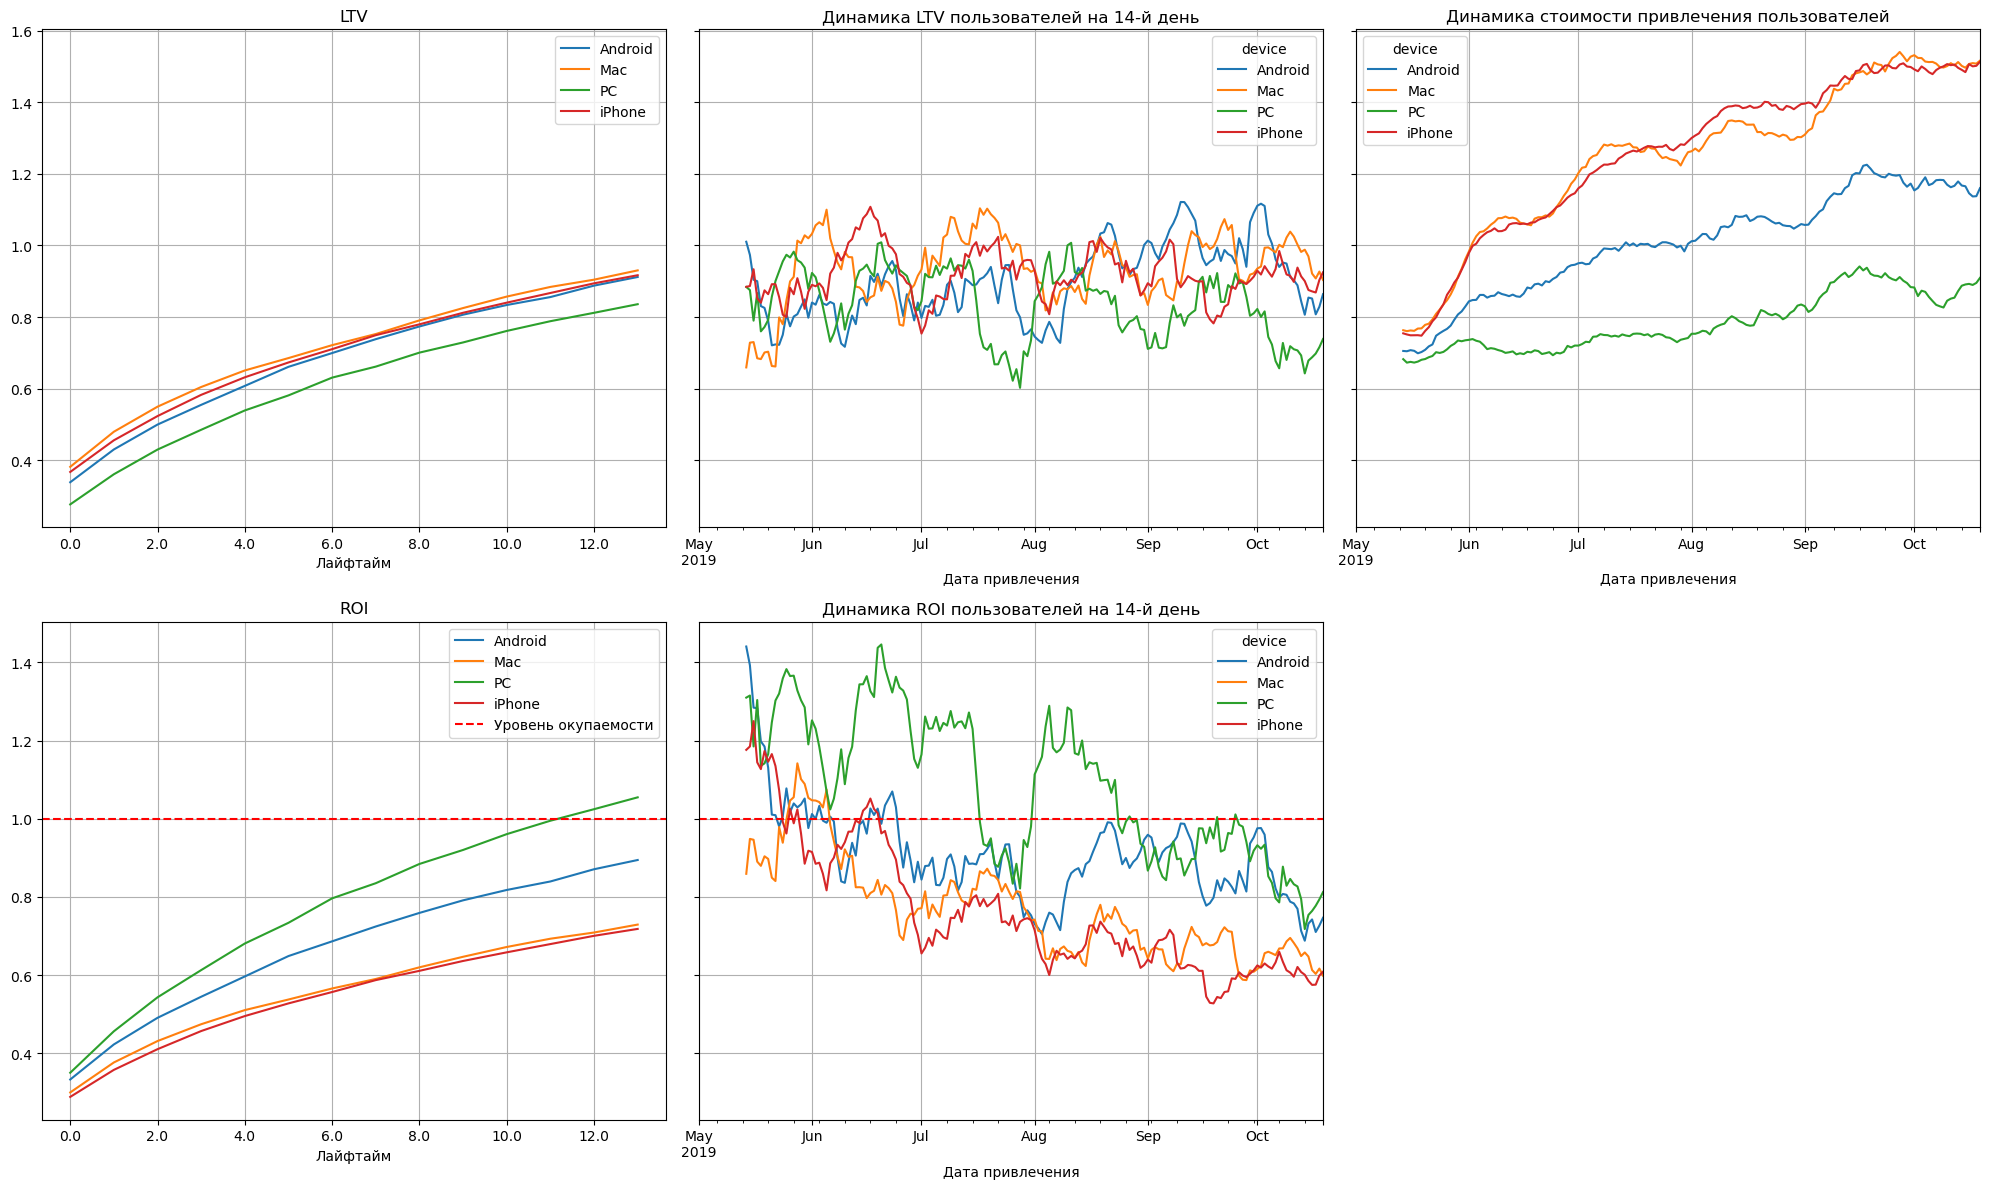

In [46]:
# рассчитываем LTV и ROI
observation_date = datetime(2019, 11, 1)  # момент анализа
analysis_horizon = 14 # горизонт анализа

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, analysis_horizon, dimensions=['device'])

plot_ltv_roi(ltv, ltv_history, roi, roi_history, analysis_horizon, window=14)
    
#ltv
#roi

- Выделяеются группы пользователеё продукции Apple.\
При том, что LTV у них несколько выше, чем у других, стоимость их привдлечения выше и растёт с большей скоростью.\
Окупаемость ниже всех.
- Единственная группа, пересекающая точку окупаемости на 12 лайфтайм - PC. Но это суммарно за период.
- Окупаемость падает у всех групп на протяжении 6 месяцев. Ниже точки окупаемости уходят со временем и пользователи PC.

### LTV и ROI. Графики динамики LTV, CAC и ROI по рекламным каналам

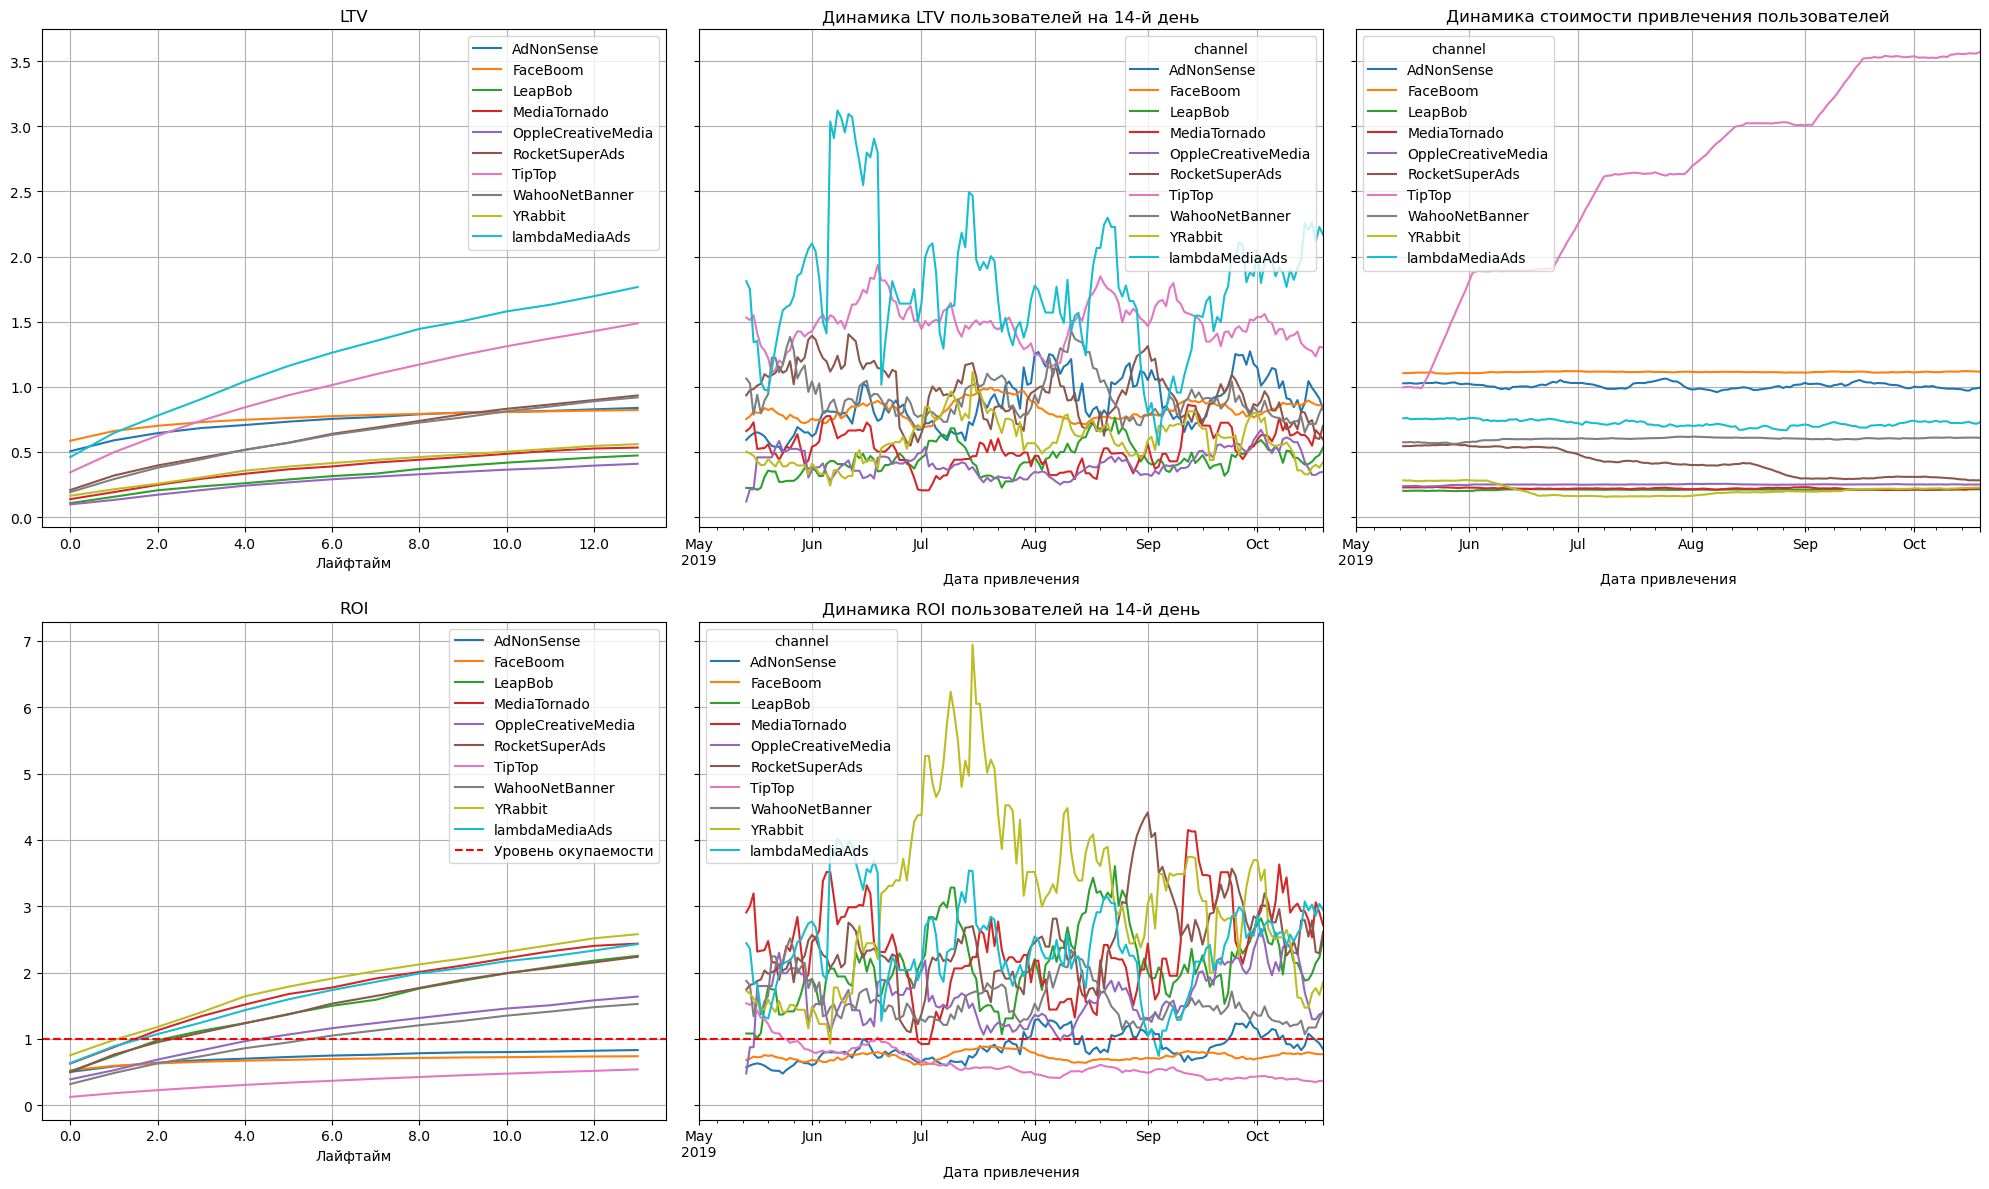

cohort_size  0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  \
channel                                                                        
AdNonSense                 3702 0.51 0.59 0.64 0.68 0.71 0.73 0.75 0.77 0.79   
FaceBoom                  27544 0.59 0.66 0.70 0.73 0.75 0.76 0.77 0.78 0.79   
LeapBob                    8103 0.11 0.16 0.21 0.24 0.26 0.29 0.31 0.33 0.37   
MediaTornado               4167 0.14 0.19 0.25 0.29 0.33 0.37 0.39 0.42 0.44   
OppleCreativeMedia         8139 0.10 0.13 0.17 0.21 0.24 0.27 0.29 0.31 0.33   
RocketSuperAds             4251 0.21 0.32 0.40 0.46 0.52 0.57 0.64 0.69 0.74   
TipTop                    18498 0.34 0.50 0.62 0.74 0.84 0.94 1.01 1.10 1.17   
WahooNetBanner             8082 0.19 0.29 0.38 0.44 0.52 0.57 0.63 0.68 0.73   
YRabbit                    4102 0.16 0.21 0.26 0.30 0.36 0.39 0.41 0.44 0.46   
lambdaMediaAds             2056 0.46 0.65 0.78 0.91 1.04 1.16 1.26 1.35 1.44   

                    9.0  10.0  11.0  12.0  13.0  
channel                                          
AdNonSense         0.80  0.81  0.82  0.83  0.84  
FaceBoom           0.80  0.81  0.81  0.82  0.82  
LeapBob            0.39  0.42  0.44  0.46  0.47  
MediaTornado       0.46  0.49  0.51  0.53  0.53  
OppleCreativeMedia 0.35  0.36  0.38  0.40  0.41  
RocketSuperAds     0.79  0.83  0.86  0.90  0.93  
TipTop             1.25  1.31  1.37  1.43  1.49  
WahooNetBanner     0.77  0.81  0.85  0.89  0.92  
YRabbit            0.48  0.50  0.52  0.55  0.56  
lambdaMediaAds     1.51  1.58  1.63  1.70  1.77

In [47]:
# рассчитываем LTV и ROI
observation_date = datetime(2019, 11, 1)  # момент анализа
analysis_horizon = 14 # горизонт анализа

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, analysis_horizon, dimensions=['channel'])

plot_ltv_roi(ltv, ltv_history, roi, roi_history, analysis_horizon, window=14)
    
ltv  
#roi

В анализе с разбивкой по каналам обращает на себя внимание следующее:
- Стоимость привлечения в канале TipTop значительно выше, чем в других и ростёт каждый месяц. Стоимость привлечения в остальных каналах со времнем не меняется.
- **Каналы AdNonSense, FaceBoom и TipTop   не окупают вложения** и эта ситуация неизменна на протяжении 6 месяцев.

#### Каналы США

Та как органический трафик у нас уже убран, на этом этапе выбираем только США

In [48]:
# выбираем United States
profiles = profiles[profiles['region'] == 'United States']
visits = visits[visits['region'] == 'United States']

# проверяем
display (visits['region'].unique())
profiles['region'].unique()

array(['United States'], dtype=object)

array(['United States'], dtype=object)

**Удержание по каналам (США)**

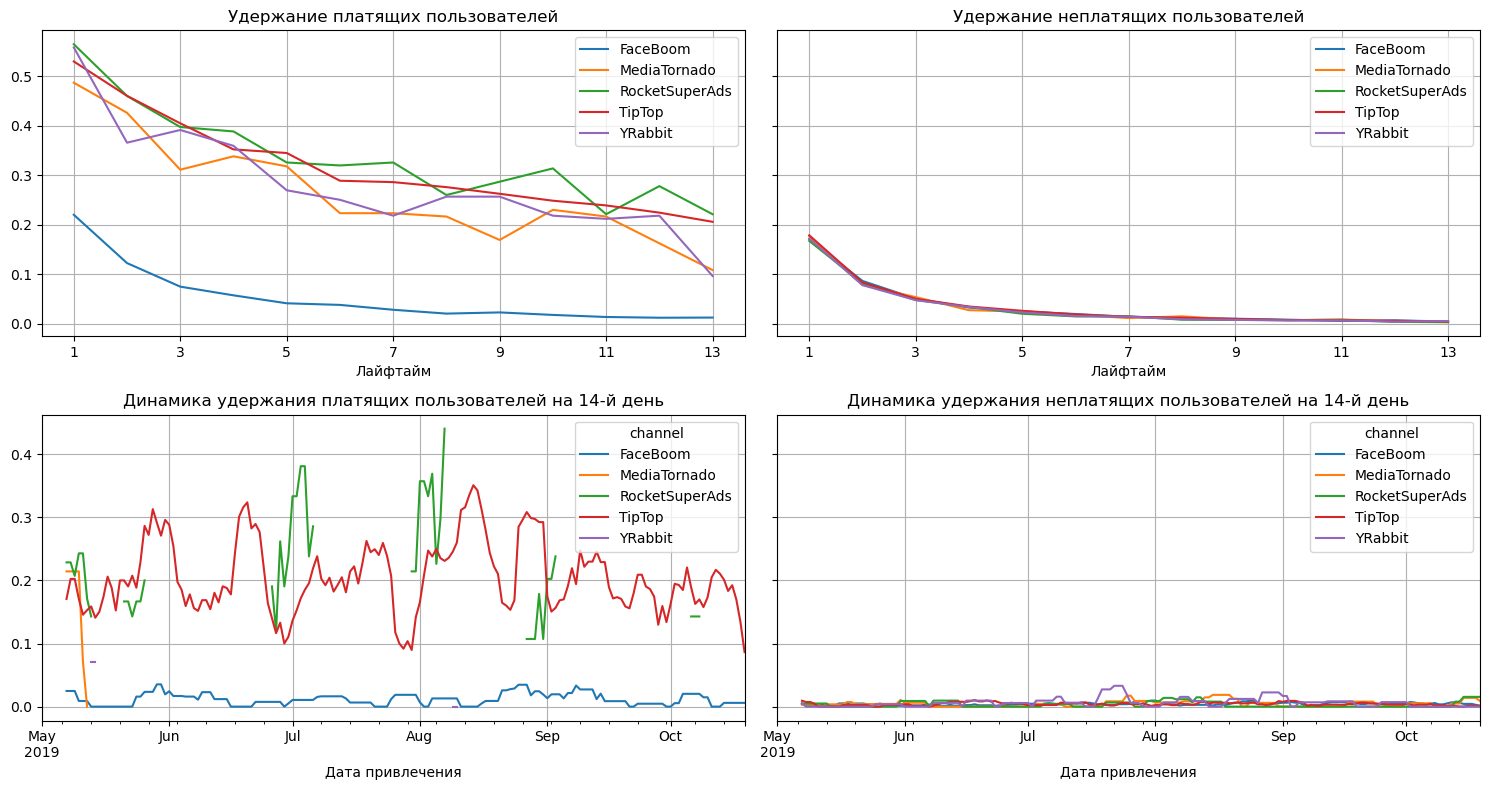

In [49]:
# вызываем функции
# задаём момент анализа и горизонт 
observation_date = datetime(2019, 11, 1)  # момент анализа
analysis_horizon = 14 # горизонт анализа

retention_raw, retention, retention_history = get_retention(
    profiles, visits, observation_date, analysis_horizon, dimensions=['channel', 'payer'])

plot_retention(retention, retention_history, analysis_horizon, 7) 
#display (retention_raw)
#display(retention)
#retention_history

**Конверсия по каналам (США)**

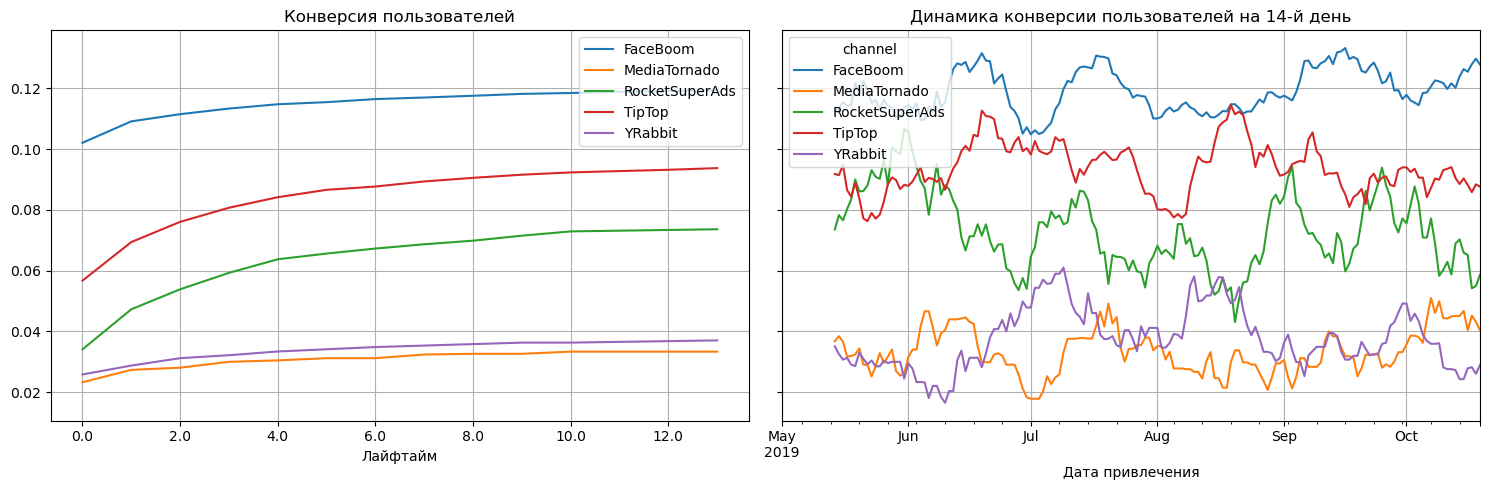

cohort_size  0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0  \
channel                                                                         
FaceBoom              27544 0.10 0.11 0.11 0.11 0.11 0.12 0.12 0.12 0.12 0.12   
MediaTornado           4167 0.02 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03   
RocketSuperAds         4251 0.03 0.05 0.05 0.06 0.06 0.07 0.07 0.07 0.07 0.07   
TipTop                18498 0.06 0.07 0.08 0.08 0.08 0.09 0.09 0.09 0.09 0.09   
YRabbit                4102 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.04 0.04 0.04   

                10.0  11.0  12.0  13.0  
channel                                 
FaceBoom        0.12  0.12  0.12  0.12  
MediaTornado    0.03  0.03  0.03  0.03  
RocketSuperAds  0.07  0.07  0.07  0.07  
TipTop          0.09  0.09  0.09  0.09  
YRabbit         0.04  0.04  0.04  0.04

In [50]:
# задаём момент анализа и горизонт 
observation_date = datetime(2019, 11, 1)  # момент анализа
analysis_horizon = 14 # горизонт анализа

# получаем сырые данные, таблицу конверсии и таблицу динамики конверсии
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date, analysis_horizon, dimensions=['channel'])

plot_conversion(conversion, conversion_history, analysis_horizon, window=14) 
#display (conversion_raw)
display (conversion)
#conversion_history

**LTV, CAC, ROI по каналам (США)**

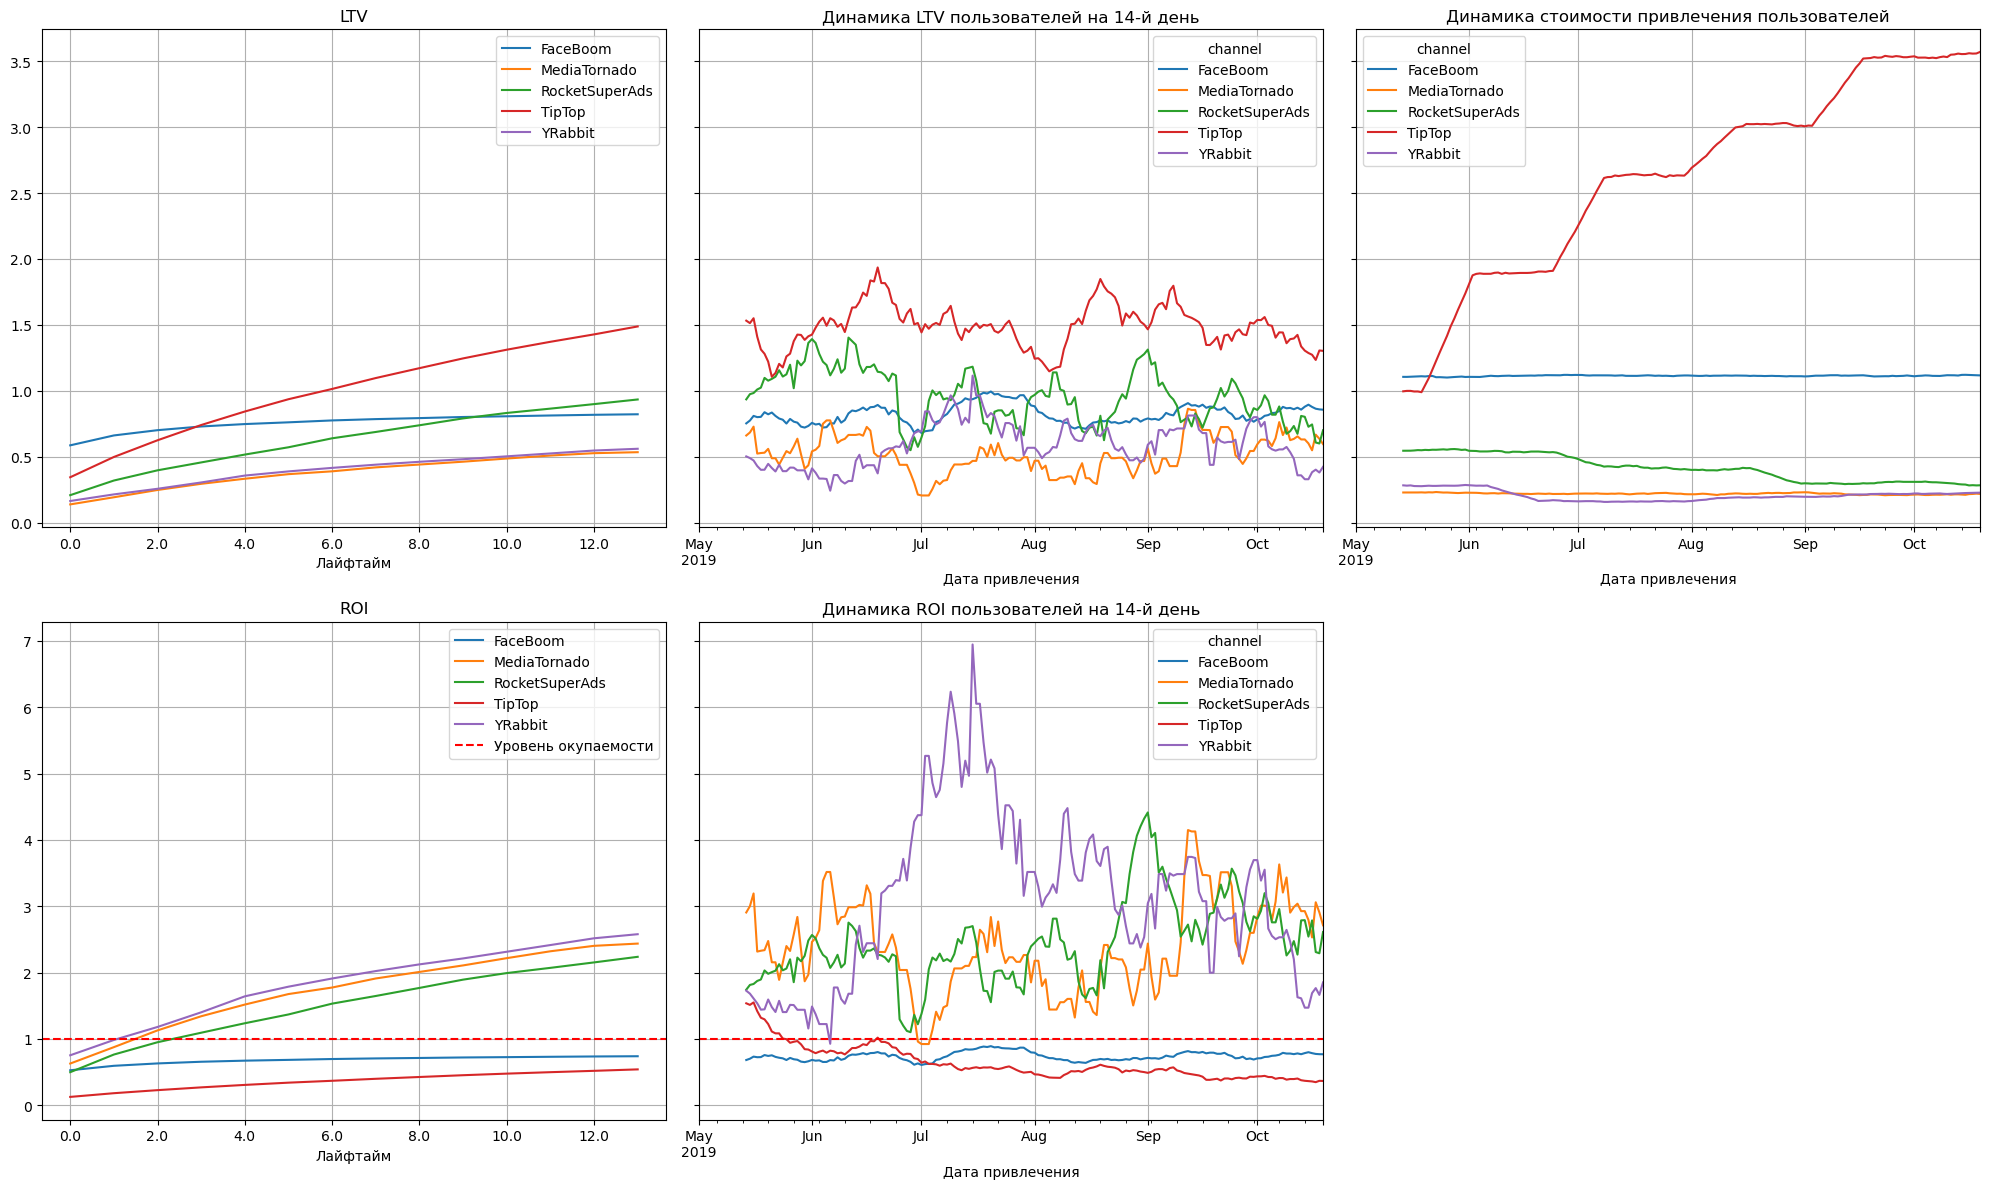

cohort_size  cac  0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  \
channel                                                                         
FaceBoom              27544 1.11 0.53 0.59 0.63 0.65 0.67 0.68 0.70 0.70 0.71   
MediaTornado           4167 0.22 0.63 0.87 1.13 1.34 1.52 1.68 1.77 1.91 2.01   
RocketSuperAds         4251 0.42 0.50 0.76 0.95 1.09 1.24 1.37 1.53 1.65 1.77   
TipTop                18498 2.76 0.12 0.18 0.23 0.27 0.31 0.34 0.37 0.40 0.42   
YRabbit                4102 0.22 0.75 0.98 1.18 1.40 1.64 1.79 1.91 2.02 2.12   

                9.0  10.0  11.0  12.0  13.0  
channel                                      
FaceBoom       0.72  0.72  0.73  0.73  0.74  
MediaTornado   2.11  2.22  2.32  2.40  2.44  
RocketSuperAds 1.89  1.99  2.07  2.15  2.24  
TipTop         0.45  0.48  0.50  0.52  0.54  
YRabbit        2.21  2.31  2.41  2.52  2.58

In [51]:
# рассчитываем LTV и ROI
observation_date = datetime(2019, 11, 1)  # момент анализа
analysis_horizon = 14 # горизонт анализа

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, analysis_horizon, dimensions=['channel'])

plot_ltv_roi(ltv, ltv_history, roi, roi_history, analysis_horizon, window=14)
    
ltv  
roi

- Выводы, которые можно сделать из исследования каналов, дающих трафик из США, касаются поиска альтернативы неокупающему себя каналу TipTop.\
Эти выводы включены в раздел 6, в том числе в рекомендации отделу маркетинга по выбору рекламных каналов.

- Хорошие показатели у канала **RocketSuperAds** (имеет в США высокий LTE = 0.93 и хорошую конверсию 7%)

- Обращают на себя внимание **YRabbit** и **MediaTornado**, которые, имея скромные показатели конверсии, уверенно перодалевают точку окупаемости.

## Выводы

**- Причины неэффективности привлечени пользователей**

**- Рекомендации отделу маркетинга**

Мы обратили внимание, что практически все метрики имеют явный момент перепада - месяц июнь. Эти изменения, судя по поведению метрик, вызывают вопрос о целесообразности этих изменений.\
С другой стороны, факт наличих выраженных изменений в конкретной временной точке помогает понять причины, приведшие к негативным результатам.

### Органический трафик и его проблемы

1. Недооценка значимости органического трафика, что привело к резкому падению количества посетителей.
   > Возможные причины:
   > Изменения в SEO продвижении, отсутствие PR, имиджевой активности.
   > > **Рекомендация**. Улучшить SEO-оптимизацию  сайта с целью его лучшей видимости поисковыми системами при запросах на разныхязыках.\
   > > разработать PR-стратегию, цель которой добиться максимально возмозжного количества обратных ссылок на сайт.
2. Низкий уровень конверсии органического трафика, который, видимо, считается в  компании естественным, что не совсем так.
   > Это может быть вызвано, в том числе, недостатками посадочной страницы, из которой без предварительной инфармации сложно понять преимущества данного проекта. Рекламный трафик уже подготовлен рекламными материалами, органическому же приходится разбираться непосредственно  на посадочной странице, что, видимо, не просто сделать.
   > > **Рекомендация**. Переработать посадочную страницу так, чтобы без предварительной информации посетитель мог понять ценность предложения. А также добавить на страницу дополнительные опции, которые могут помочь удержанию и последующей конвертации посетителя. 

### Рекламный трафик

1. Обращает на себя внимание практически полная идентичность поведения стоимости привлечения (CAC) у следующих срезов:
   - затраты на рекламу в каналах для пользователеё продукции Apple (ROI ниже окупаемости, около 0.7),
   - затраты на рекламу в США (ROI ниже окупаемости, около 0.7),
   - затраты на рекламу в канале TipTop (ROI ниже окупаемости = 0.51).
   > Очевидно, судя по схожести форм графиков, что эти параметры связаны единством рекламной стратегии - реклама в TipTop, ориентированая на пользователей Apple, находящихся в США.
   > > **Рекомендация**. Уменьшить финансирование какнали TipTop, (сейчас это **52 неокупающихся процента** рекламного бюджета) и одновременно скорректировать географический таргетинг в и переработать содержание рекламного сообщения, сделав его более универсальным для пользователей всех платформ.


2. Ещё два канала ниже точки окупаемости. Это FaceBoom (показатель 0.74) и AdNonSense (показатель 0.83). У них высокая конверсия, но одновременно более низкий уровень удержания, чем у других каналов. Приэтом каналы имеют примерно одинаковый CAC.\
*(На FaceBoom приходится 31 % всего бюджета)*
   > **Рекомендация**. Преверить причину более низкого удержания посетителей с этих каналов.
   > Удержание - комплексный процесс, поэтому мы можем дать только общие рекомендации.
   > - По всей видимости, проблема в том, что ожидания перешедших из этих каналов не полностью оправдываются - неполное соответсие рекламному сообщению, проблемы с обратной связью и т.п. Рекомендуем поработать над таргетингом и формулировкой рекламного сообщения в этих каналах. Ожидается, что улучшение метрики Удержание поможет увеличить LTE, потенциал для чего есть, судя по некоторым другим каналам.
   
3. Каналы недооцененные и недофинансированные. Это каналы - lambdaMediaAds и RocketSuperAds. Они имеют высокий LTV (1,77 и 0,93 соответственно) и конверсию (10 и 7 % соответственно), оба - выше точки окупаемости.
   > **Рекомендация**. Увеличить рекламные бюджеты этих каналов. Увеличить частоту показов рекламы, использовать интерактивные методы взаимодействия с аудиторией каналов.
   > 
7. Стоит обратить внимание на WahooNetBanner для Европы. У него высокий LTV = 0,97, канал выше точки окупаемости, но имеет низкую конверсию. Надо иметь ввиду, что конверсия упала в июне во всех странах, кроме США.
   > Вызвано это, видимо, переориентированием в июне рекламной стратегии на США (о чём написано выше). Можем предположить, что рекламное сообщение было также переработано с ориентиром на американцев.
   > > **Рекомендация**. Дифференцировать рекламные сообщения с учётом особенностей европейского и американского рынков.

8. Пользователи PC дают меньшую конверсию. по сравнению с другими группами.
   > **Рекомендация**. Доработать посадочную страницу так, чтоб увеличить привлекательность продукта в том числе доя пользователей PC, дав понячть, что им продукт также подходит.
    

### Резюмируем рекомендации

- Улучшить SEO-оптимизацию сайта с целью его лучшей видимости поисковыми системами при запросах на разных языках.
- Разработать PR-стратегию, цель которой добиться максимально возмозжного количества обратных ссылок на сайт.
- Переработать посадочную страницу так, чтобы без предварительной информации посетитель мог понять ценность предложения.\
  Добавить на страницу опции, которые помогут удержанию и последующей конвертации посетителя.\
  Доработать посадочную страницу так, чтоб квеличить привлекательность продукта для пользователей PC.
- Дифференцировать рекламные сообщения с учётом особенностей европейского и американского рынков.
 
  
- **Уменьшить финансирование какнала TipTop**. Обязательно - с одновременной корректировкой географического таргетинга в и переработкой рекламного сообщения.\
  Если корректировка таргетинга и контента невозможны - направить его бюджет на **RocketSuperAds** (имеет в США высокий LTE = 0.93 и хорошую конверсию 7%), а также **YRabbit** и **MediaTornado**, которые, имея скромные показатели конверсии, но их трафик уверенно преодалевает точку окупаемости.
- Каналы **FaceBoom и AdNonSense** - поработать над таргетингом и формулировкой рекламного сообщения (см. выше) в этих каналах с целью улучшение метрики Удержание (что должно привести к росту LTE).
- Каналы **lambdaMediaAds и RocketSuperAds - увеличить рекламные бюджеты**.
- При перераспределении бюджета TipTop - увеличить бюджеты **YRabbit** и **MediaTornado**.\
  .
